In [1]:
from IPython.display import display, HTML

In [2]:
display(HTML("""
<style>
 .messagebox{
     border-radius: 2px;
     padding: 1.25em 1.5em;
     border: 1px solid;
 }
.messagelightgreen{
     border-color: hsl(164deg 95% 38%);
     color: rgb(5 139 102);
     background-color: rgb(236 255 250);
 }
 .messagelightgreen b{
     color:rgb(139 77 5);
 }
 .messagebrown{
     border-color: hsl(35deg 96% 62%);
    color: rgb(143 84 4);
    background-color: rgb(255 245 234);
 }
 .messagebrown b{
     color: rgb(5 139 102);
 }
</style>"""))

In [3]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict, GridSearchCV, learning_curve
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, silhouette_samples, silhouette_score
from sklearn.svm import SVC, LinearSVC
from scikitplot.metrics import plot_confusion_matrix, plot_precision_recall, plot_roc, plot_ks_statistic, plot_calibration_curve, plot_lift_curve
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense, Activation, Flatten
import warnings
import itertools
import glob
import os
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LogisticRegression


In [4]:
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor='dimgray', linewidth=1)
plt.rcParams["patch.force_edgecolor"] = True

In [5]:
mirai_df_list = []
for file in glob.glob("Danmini/mirai/*.csv"):
    tmp_df = pd.read_csv(file, nrows=20000)
    tmp_df["target"] = "mirai-" + os.path.splitext(os.path.basename(file))[0]
    mirai_df_list.append(tmp_df)


In [6]:
gafgyt_df_list = []
for file in glob.glob("Danmini/gafgyt/*.csv"):
    tmp_df = pd.read_csv(file, nrows=20000)
    tmp_df["target"] = "gafgyt-" + os.path.splitext(os.path.basename(file))[0]
    gafgyt_df_list.append(tmp_df)

In [7]:
benign_df = pd.read_csv("Danmini/benign_traffic.csv", nrows=20000)
benign_df["target"] = "benign"
gafgyt_df_list.append(benign_df)

In [8]:
df_list = mirai_df_list + gafgyt_df_list

In [9]:
df = pd.concat(df_list)

In [160]:
df.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,target
0,1.000000,566.0,0.000000e+00,1.000000,566.0,0.000000e+00,1.000000,566.0,0.000000e+00,1.000000,...,0.0,0.0,1.0,566.0,0.0,566.0,0.0,0.0,0.0,mirai-ack
1,1.996585,566.0,5.820766e-11,1.997950,566.0,5.820766e-11,1.999316,566.0,0.000000e+00,1.999932,...,0.0,0.0,1.0,566.0,0.0,566.0,0.0,0.0,0.0,mirai-ack
2,2.958989,566.0,0.000000e+00,2.975291,566.0,5.820766e-11,2.991729,566.0,5.820766e-11,2.999171,...,0.0,0.0,1.0,566.0,0.0,566.0,0.0,0.0,0.0,mirai-ack
3,3.958979,566.0,0.000000e+00,3.975285,566.0,0.000000e+00,3.991727,566.0,1.164153e-10,3.999171,...,0.0,0.0,1.0,566.0,0.0,566.0,0.0,0.0,0.0,mirai-ack
4,4.914189,566.0,1.164153e-10,4.948239,566.0,5.820766e-11,4.982654,566.0,5.820766e-11,4.998261,...,0.0,0.0,1.0,566.0,0.0,566.0,0.0,0.0,0.0,mirai-ack


In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 220000 entries, 0 to 19999
Columns: 116 entries, MI_dir_L5_weight to target
dtypes: float64(115), object(1)
memory usage: 196.4+ MB


In [162]:
def display_bar_chart(data, xvalues, yvalues, graph_title, xtitle, ytitle, legend_position_dict=None):
    fig = px.bar(data, x=xvalues, y=yvalues, color=xvalues, text_auto=True, color_continuous_scale='algae')
    fig.update_layout(title=graph_title, xaxis_title=xtitle, yaxis_title=ytitle)
    if legend_position_dict:
        fig.update_layout(legend=legend_position_dict)
    fig.show()

In [163]:
def display_pie_chart(data, xvalues, yvalues, graph_title, xtitle, ytitle, legend_position_dict=None):
    fig = px.pie(data, names=xvalues, values=yvalues, color=xvalues)
    fig.update_layout(title=graph_title, xaxis_title=xtitle, yaxis_title=ytitle)
    if legend_position_dict:
        fig.update_layout(legend=legend_position_dict)
    fig.show()

In [164]:
target_counts = df["target"].value_counts()
display_bar_chart(target_counts, target_counts.index, target_counts.values, "Target wise count", "IoT BoT Name", "No of Samples")

In [10]:
df.drop_duplicates(inplace=True)
factor = 0.10

In [166]:
def hyper_tune(number: float, value=factor) -> float:
    result = number + value
    if result > 0.9:
        return 0.96
    return result

In [167]:
binary_opt1_df = df.copy()
binary_opt1_df["target"].replace(regex=r'^mirai-[a-z]*', value='IoT-Bot-Attack', inplace=True)
binary_opt1_df["target"].replace(regex=r'^gafgyt-[a-z]*', value='IoT-Bot-Attack', inplace=True)
binary_target_counts = binary_opt1_df["target"].value_counts()
display_bar_chart(binary_target_counts, binary_target_counts.index, binary_target_counts.values, 
                  "Binary Classification: Target wise count", "Traffic Information", "No of Samples")


0 0 15


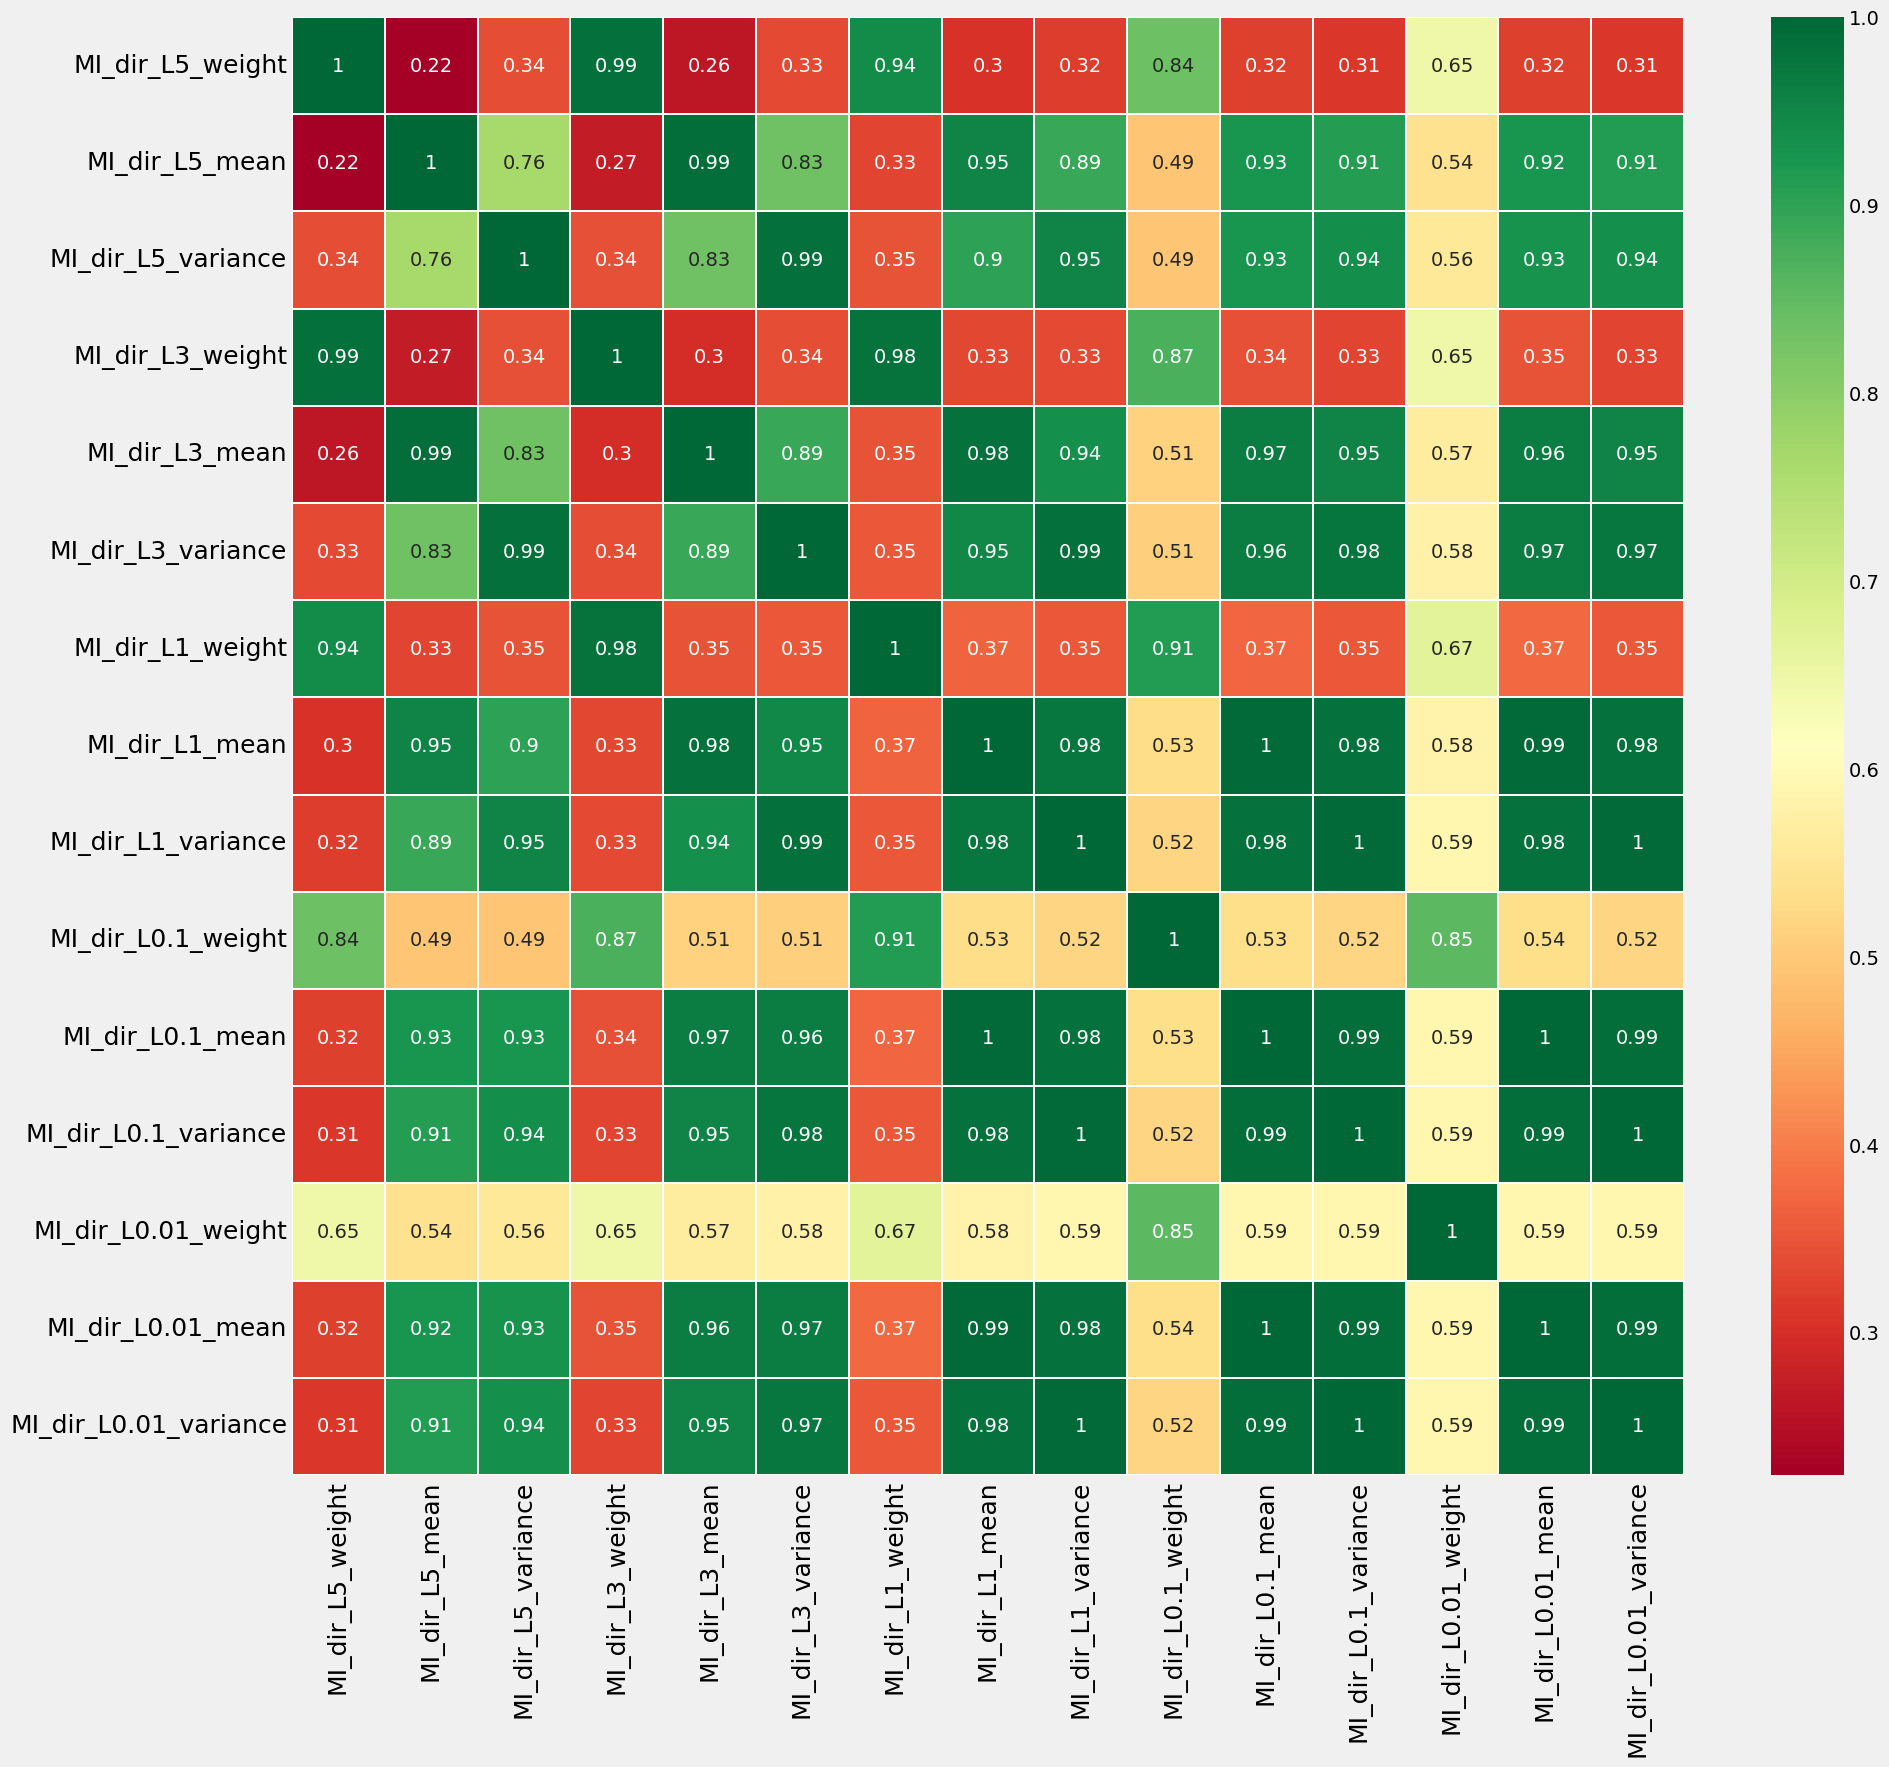

1 15 30


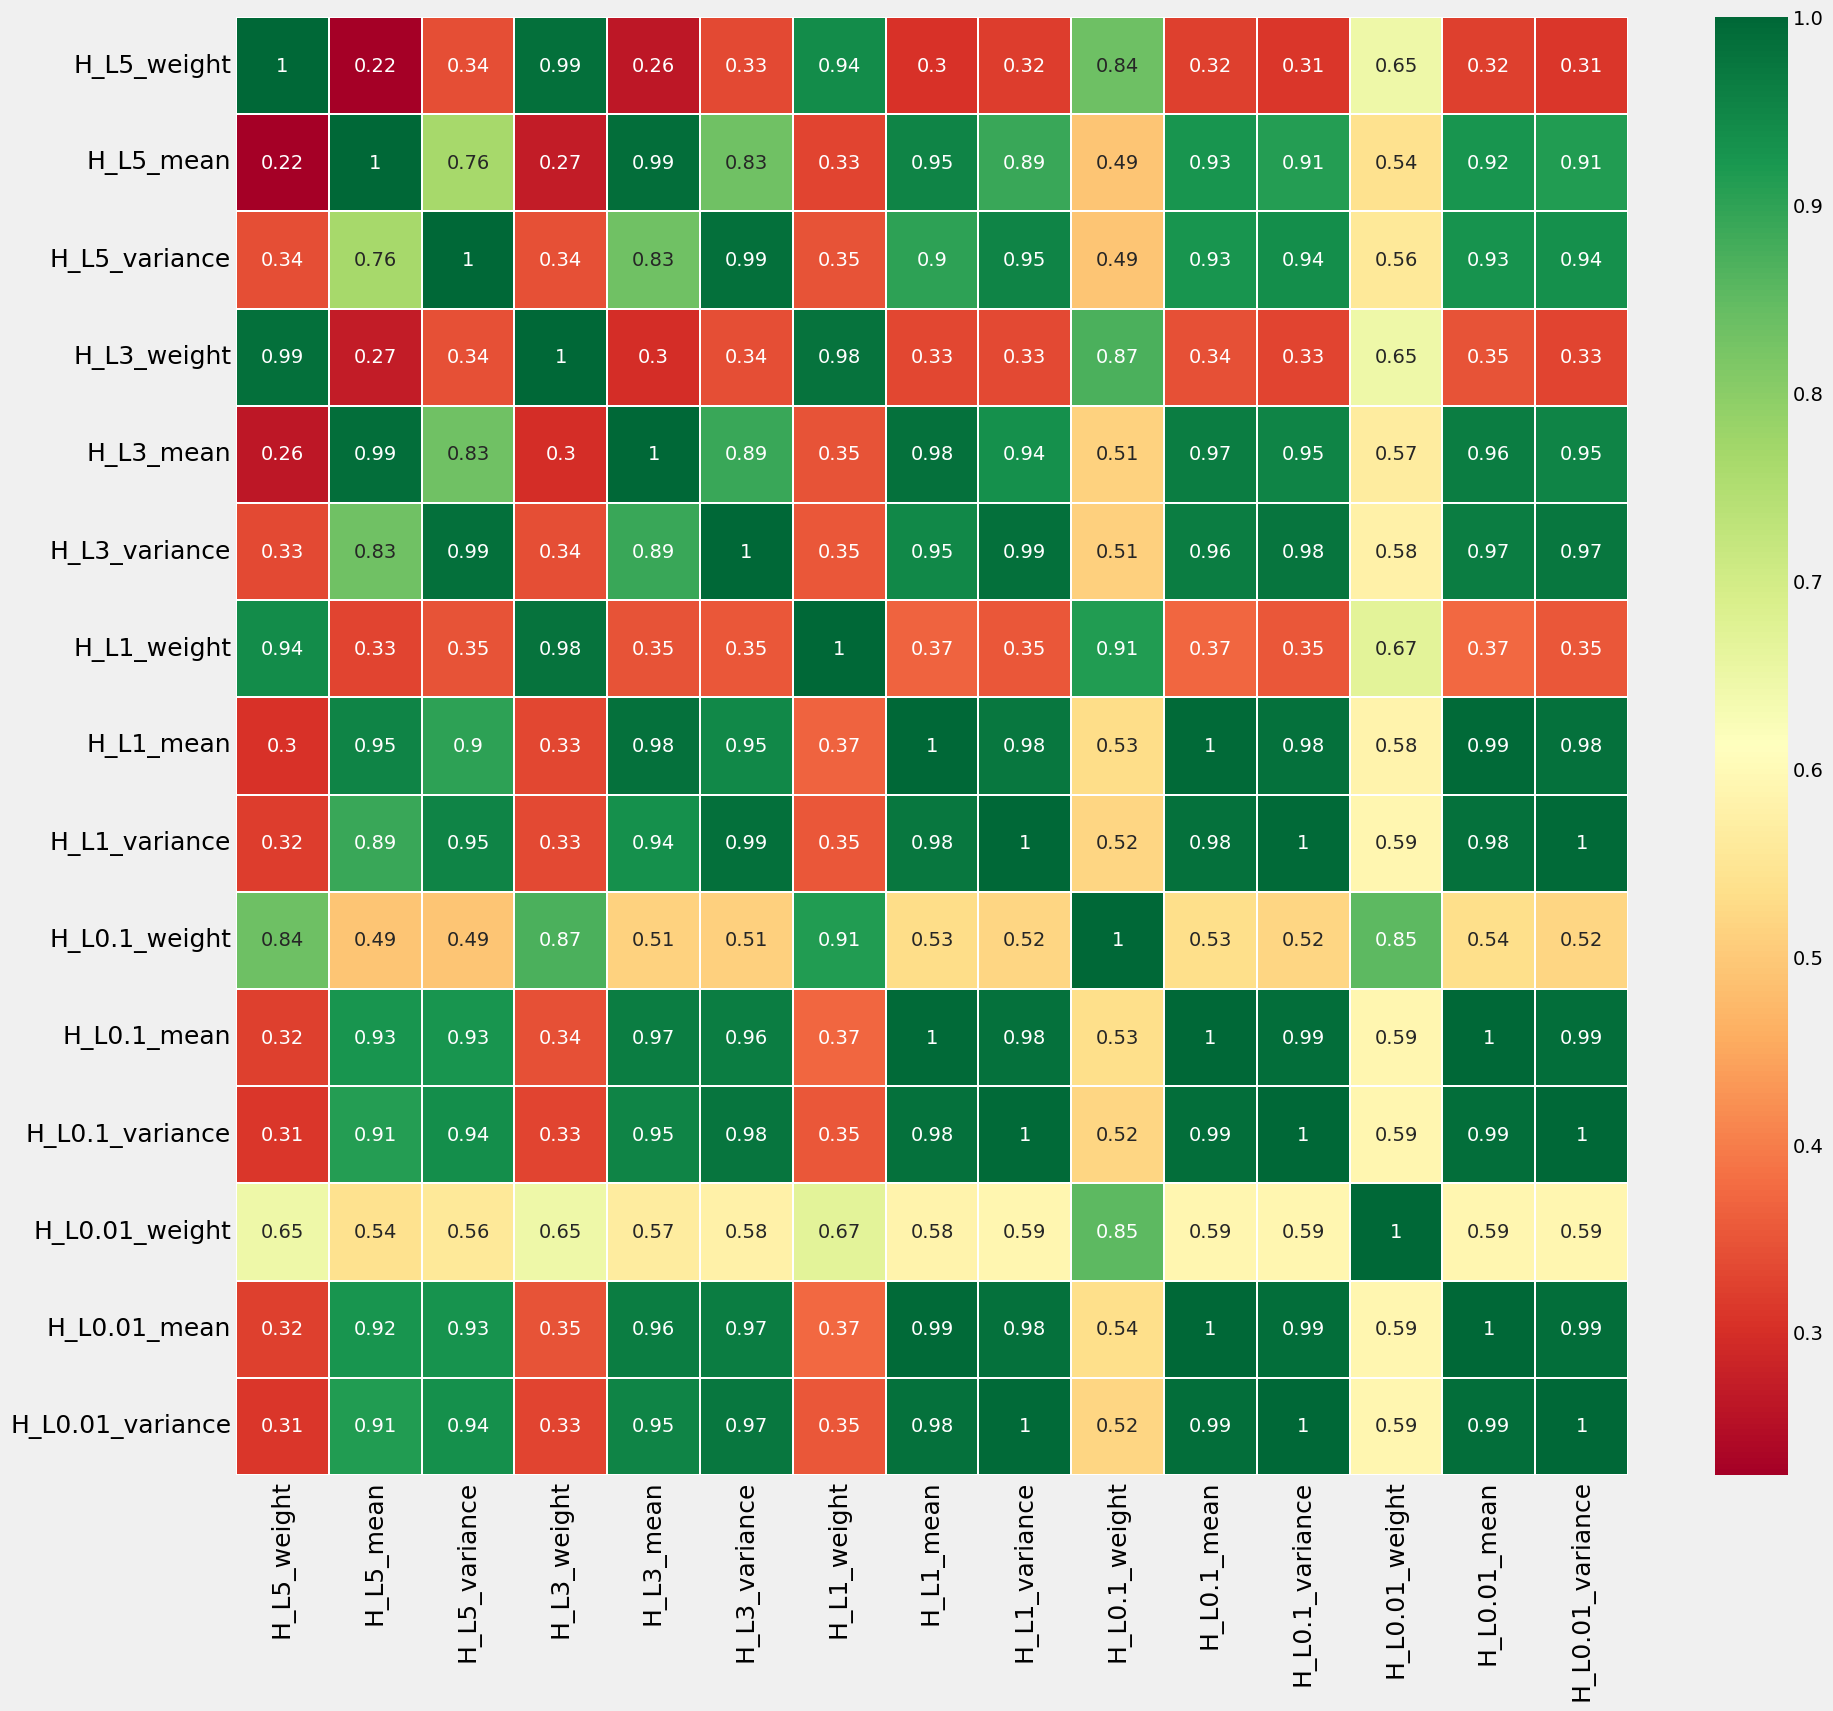

2 30 45


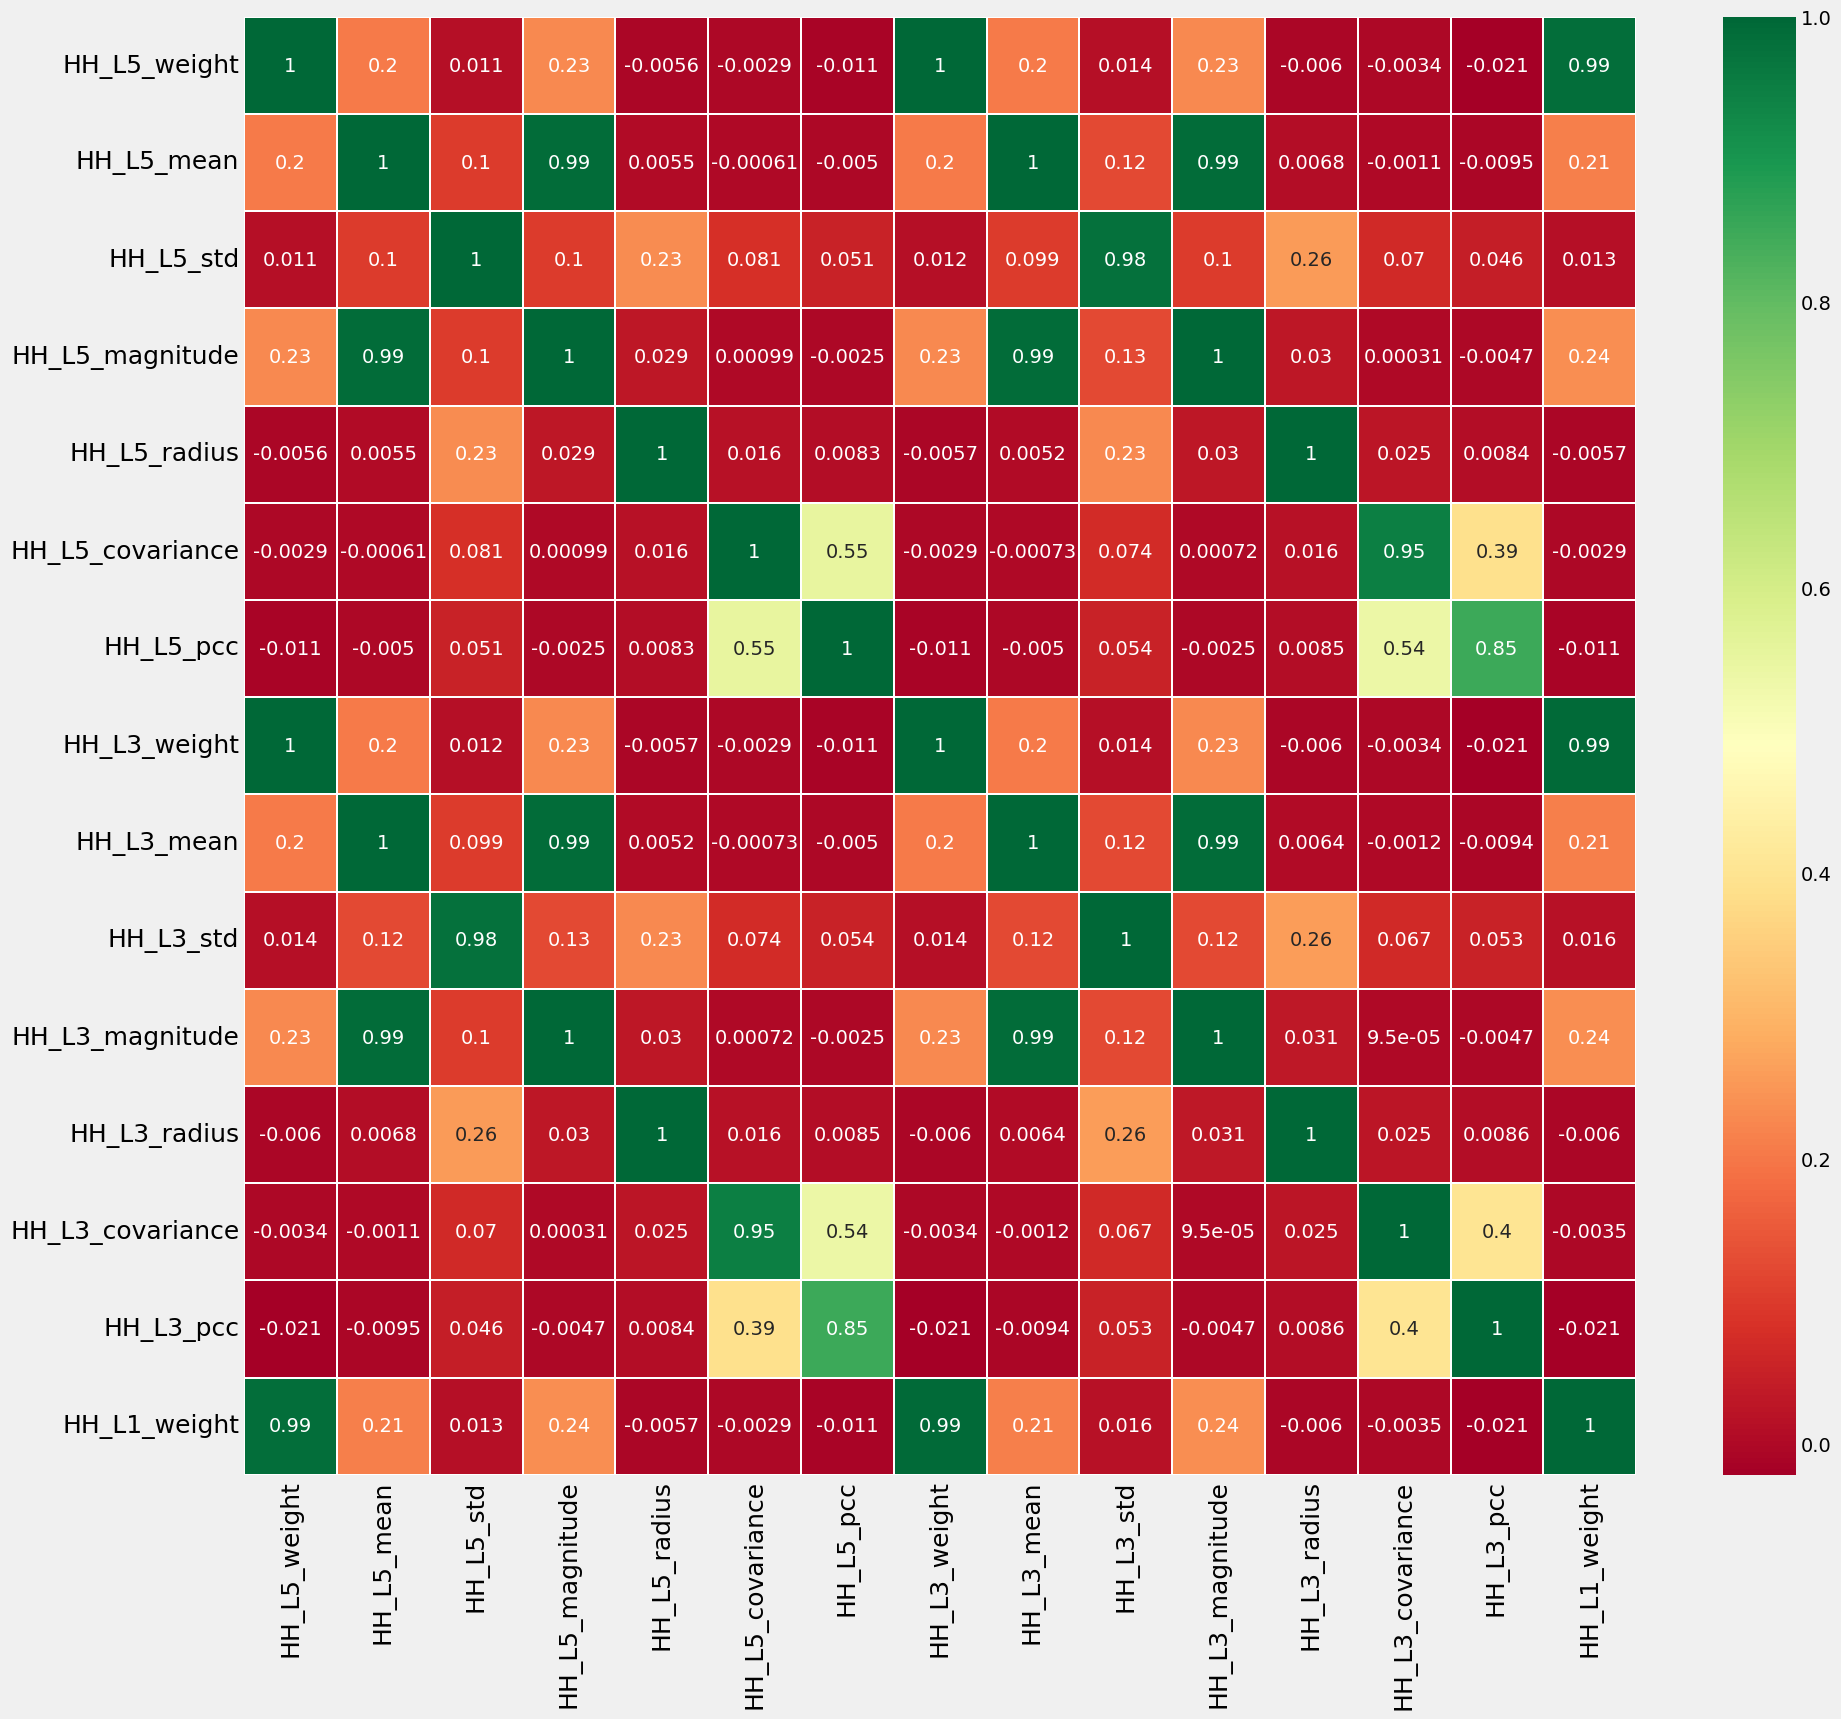

3 45 60


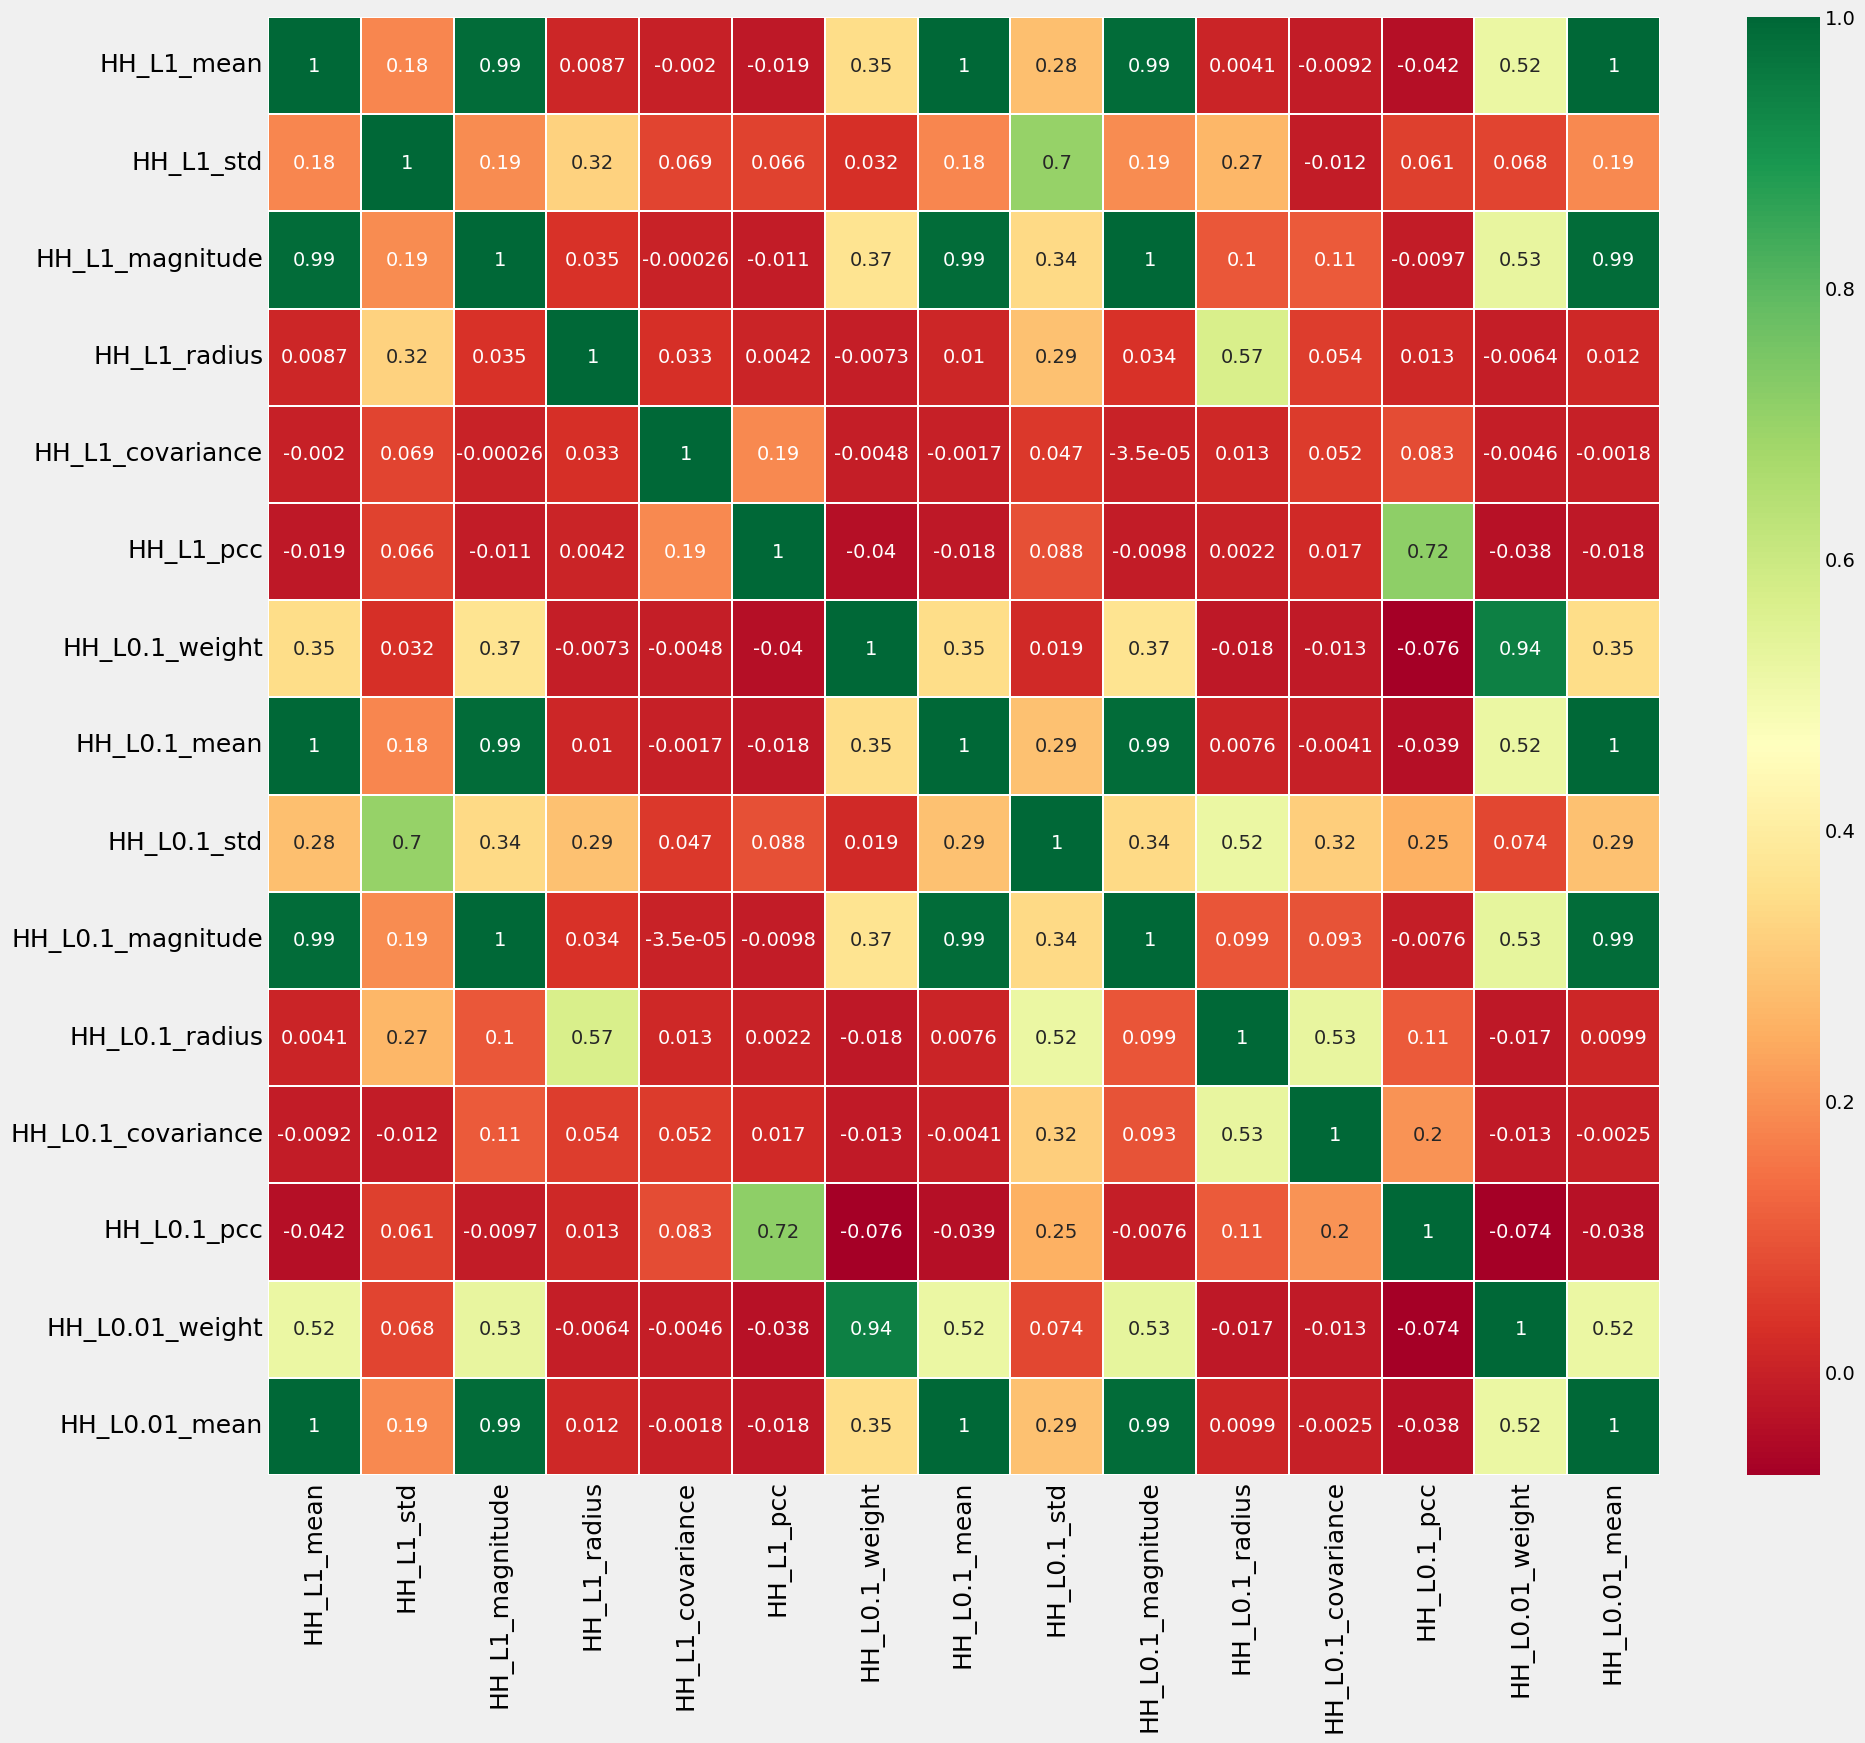

4 60 75


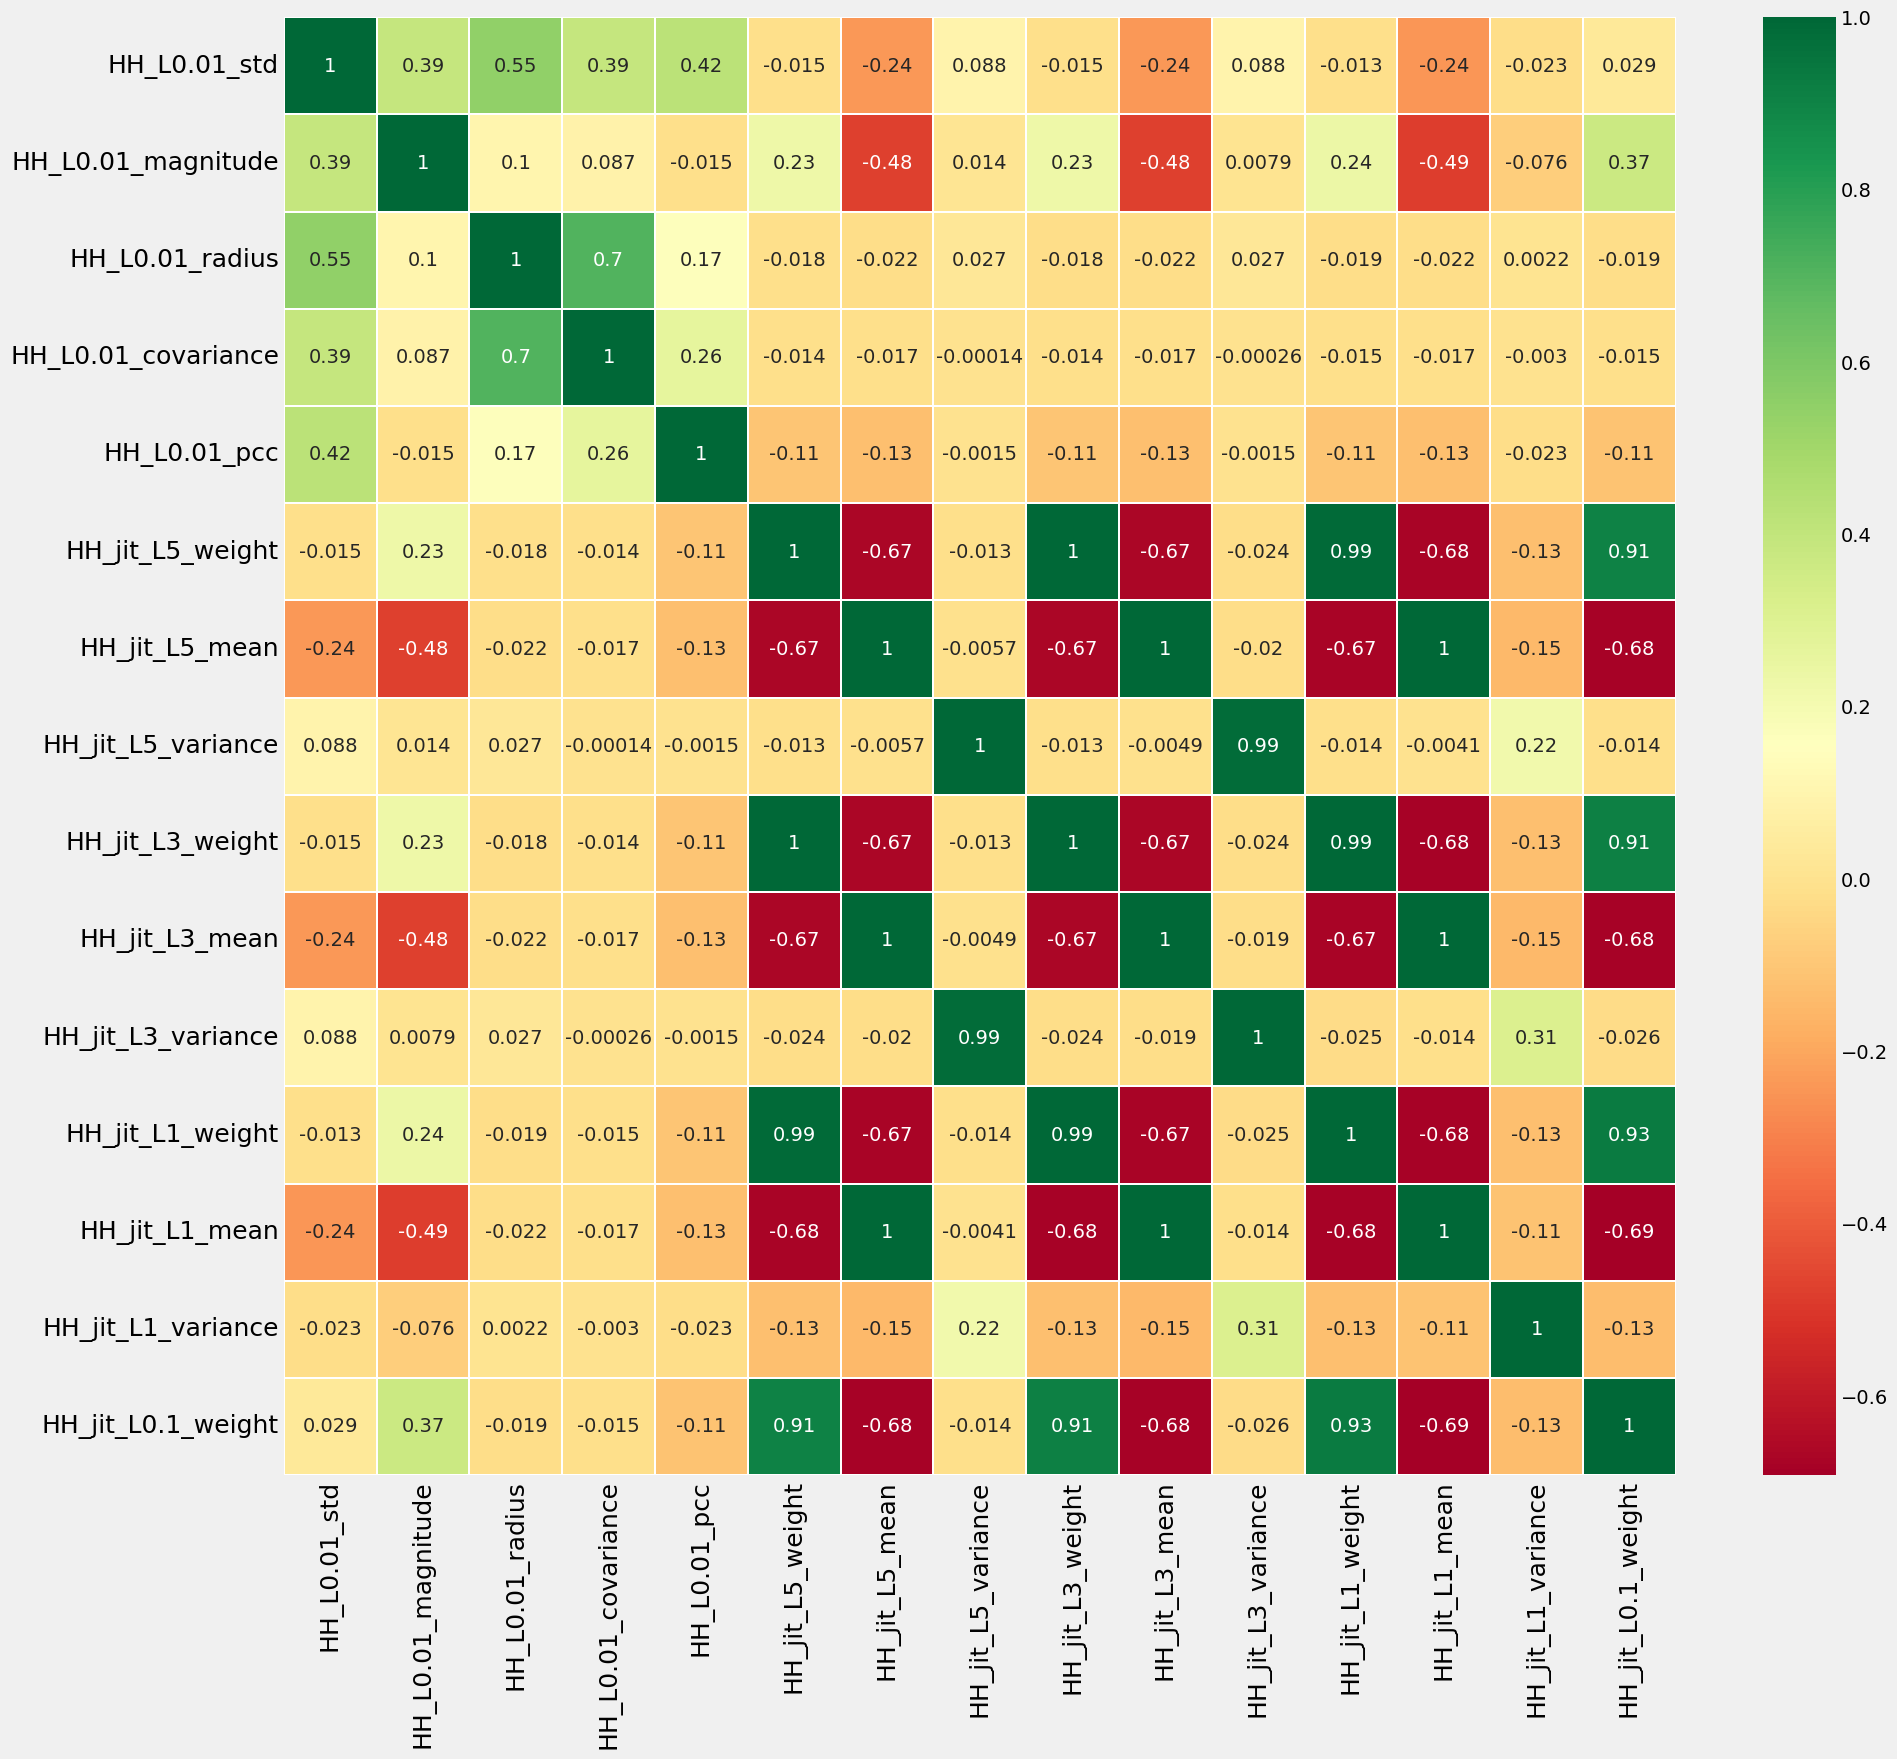

5 75 90


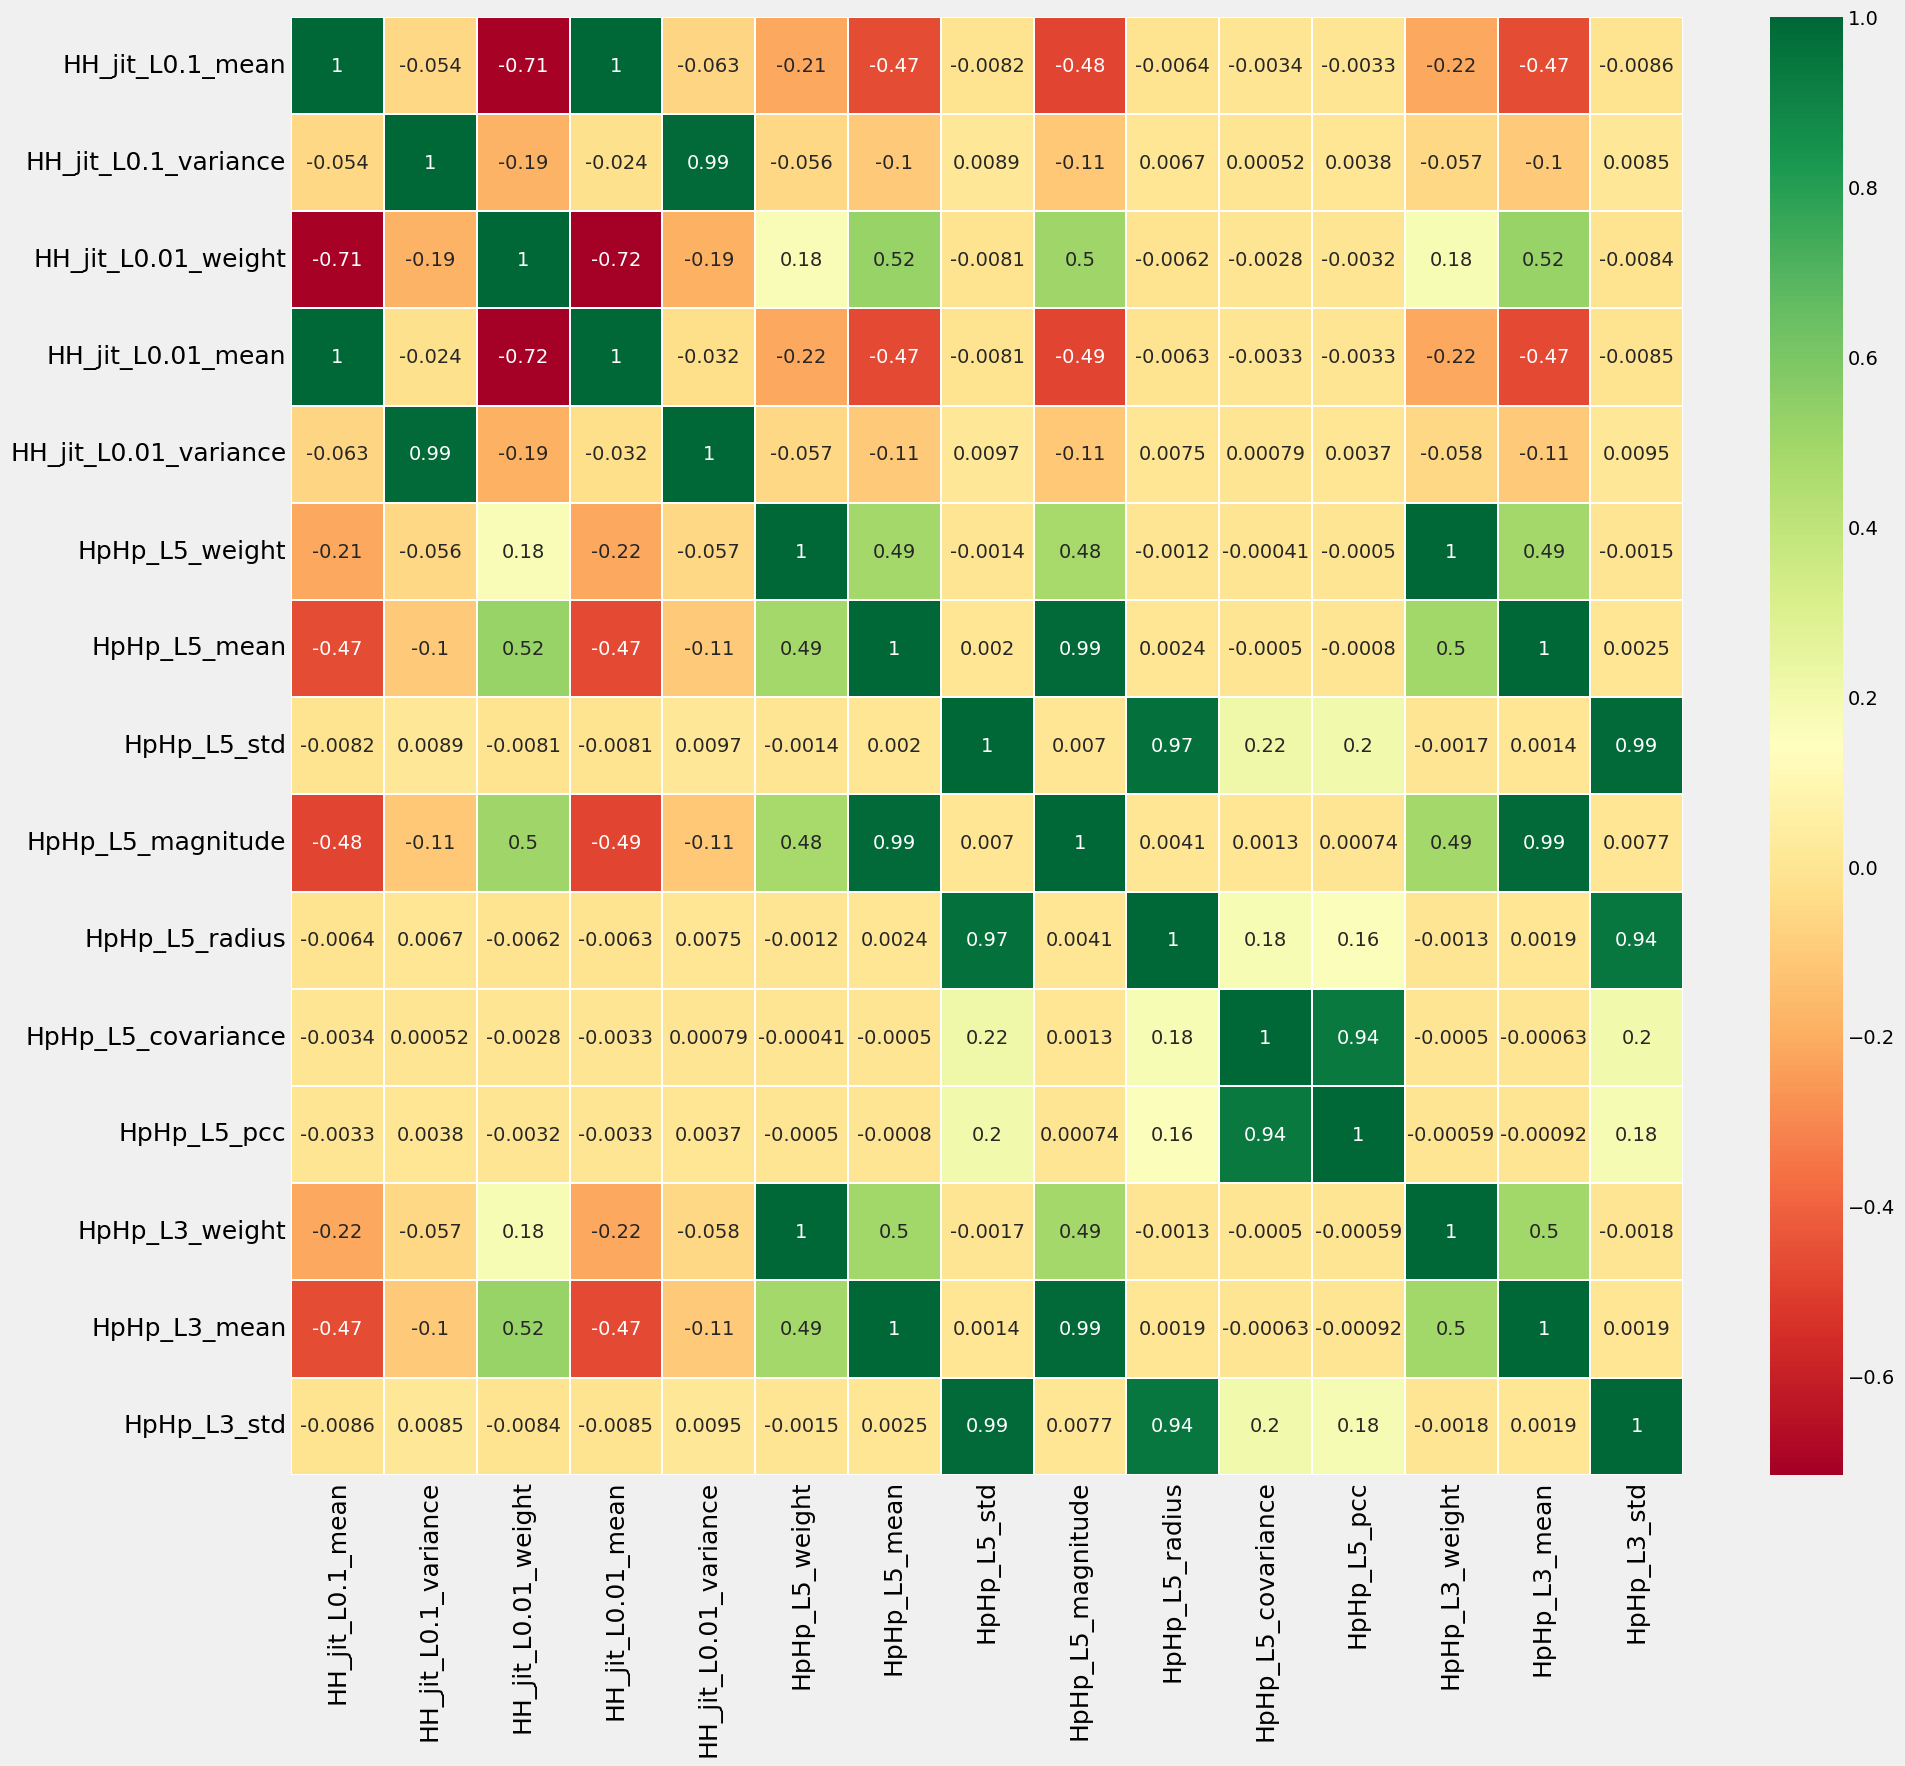

6 90 105


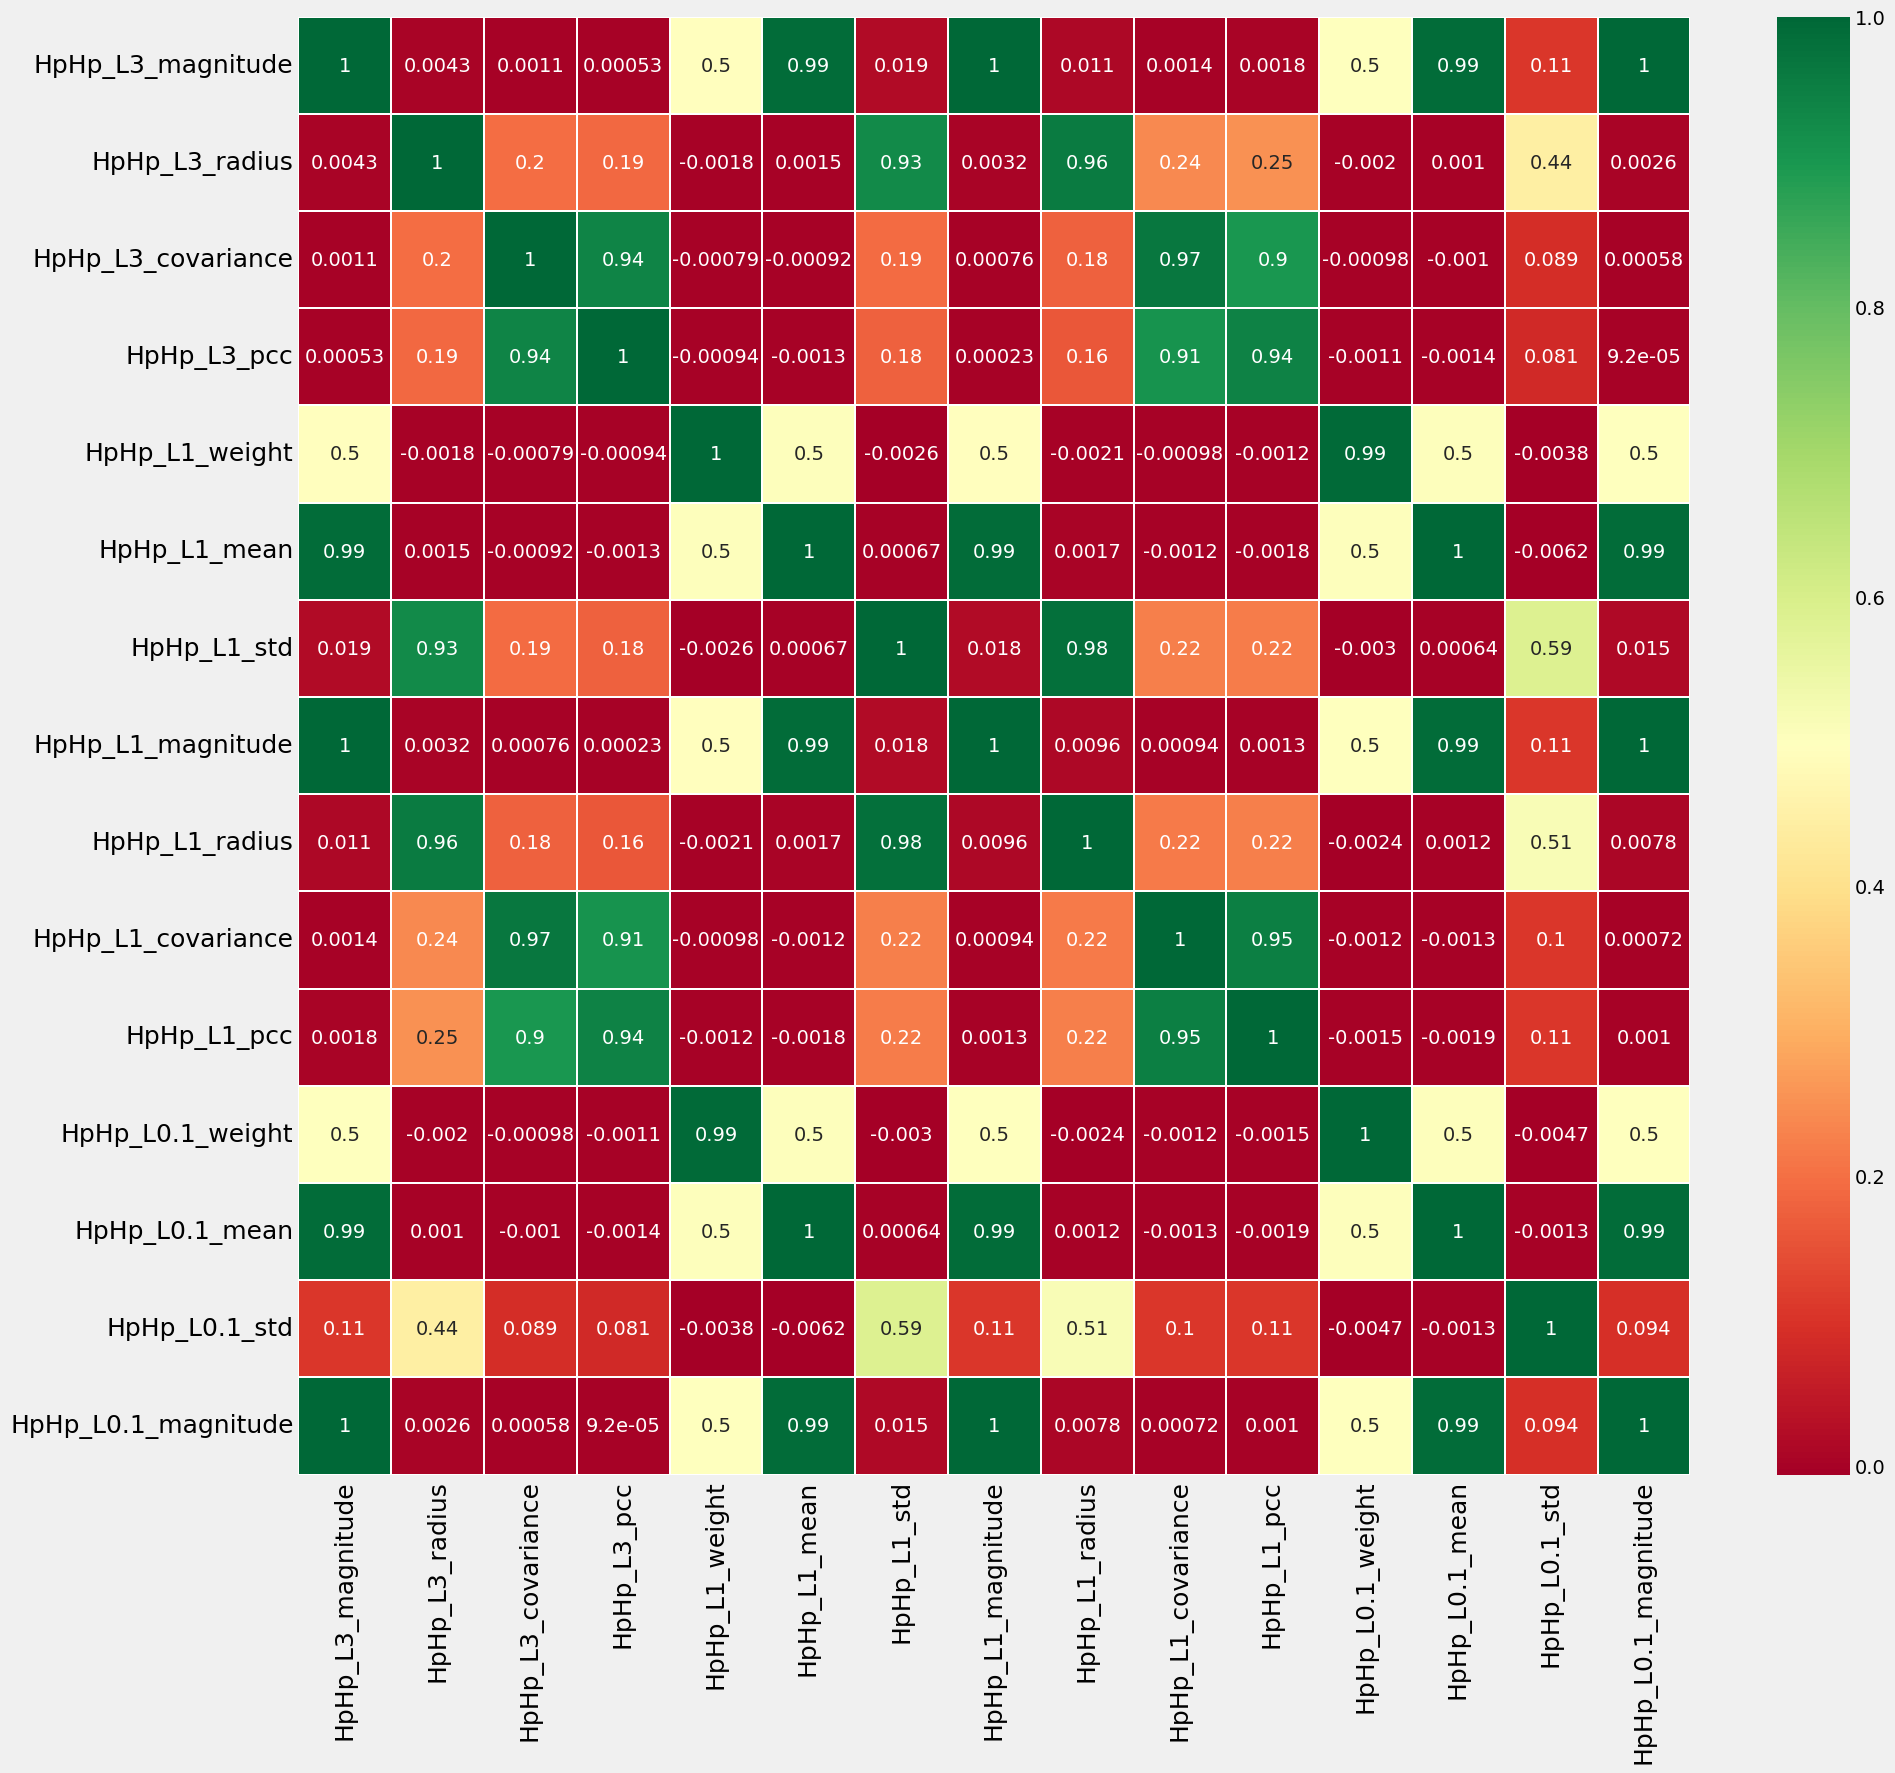

7 105 115


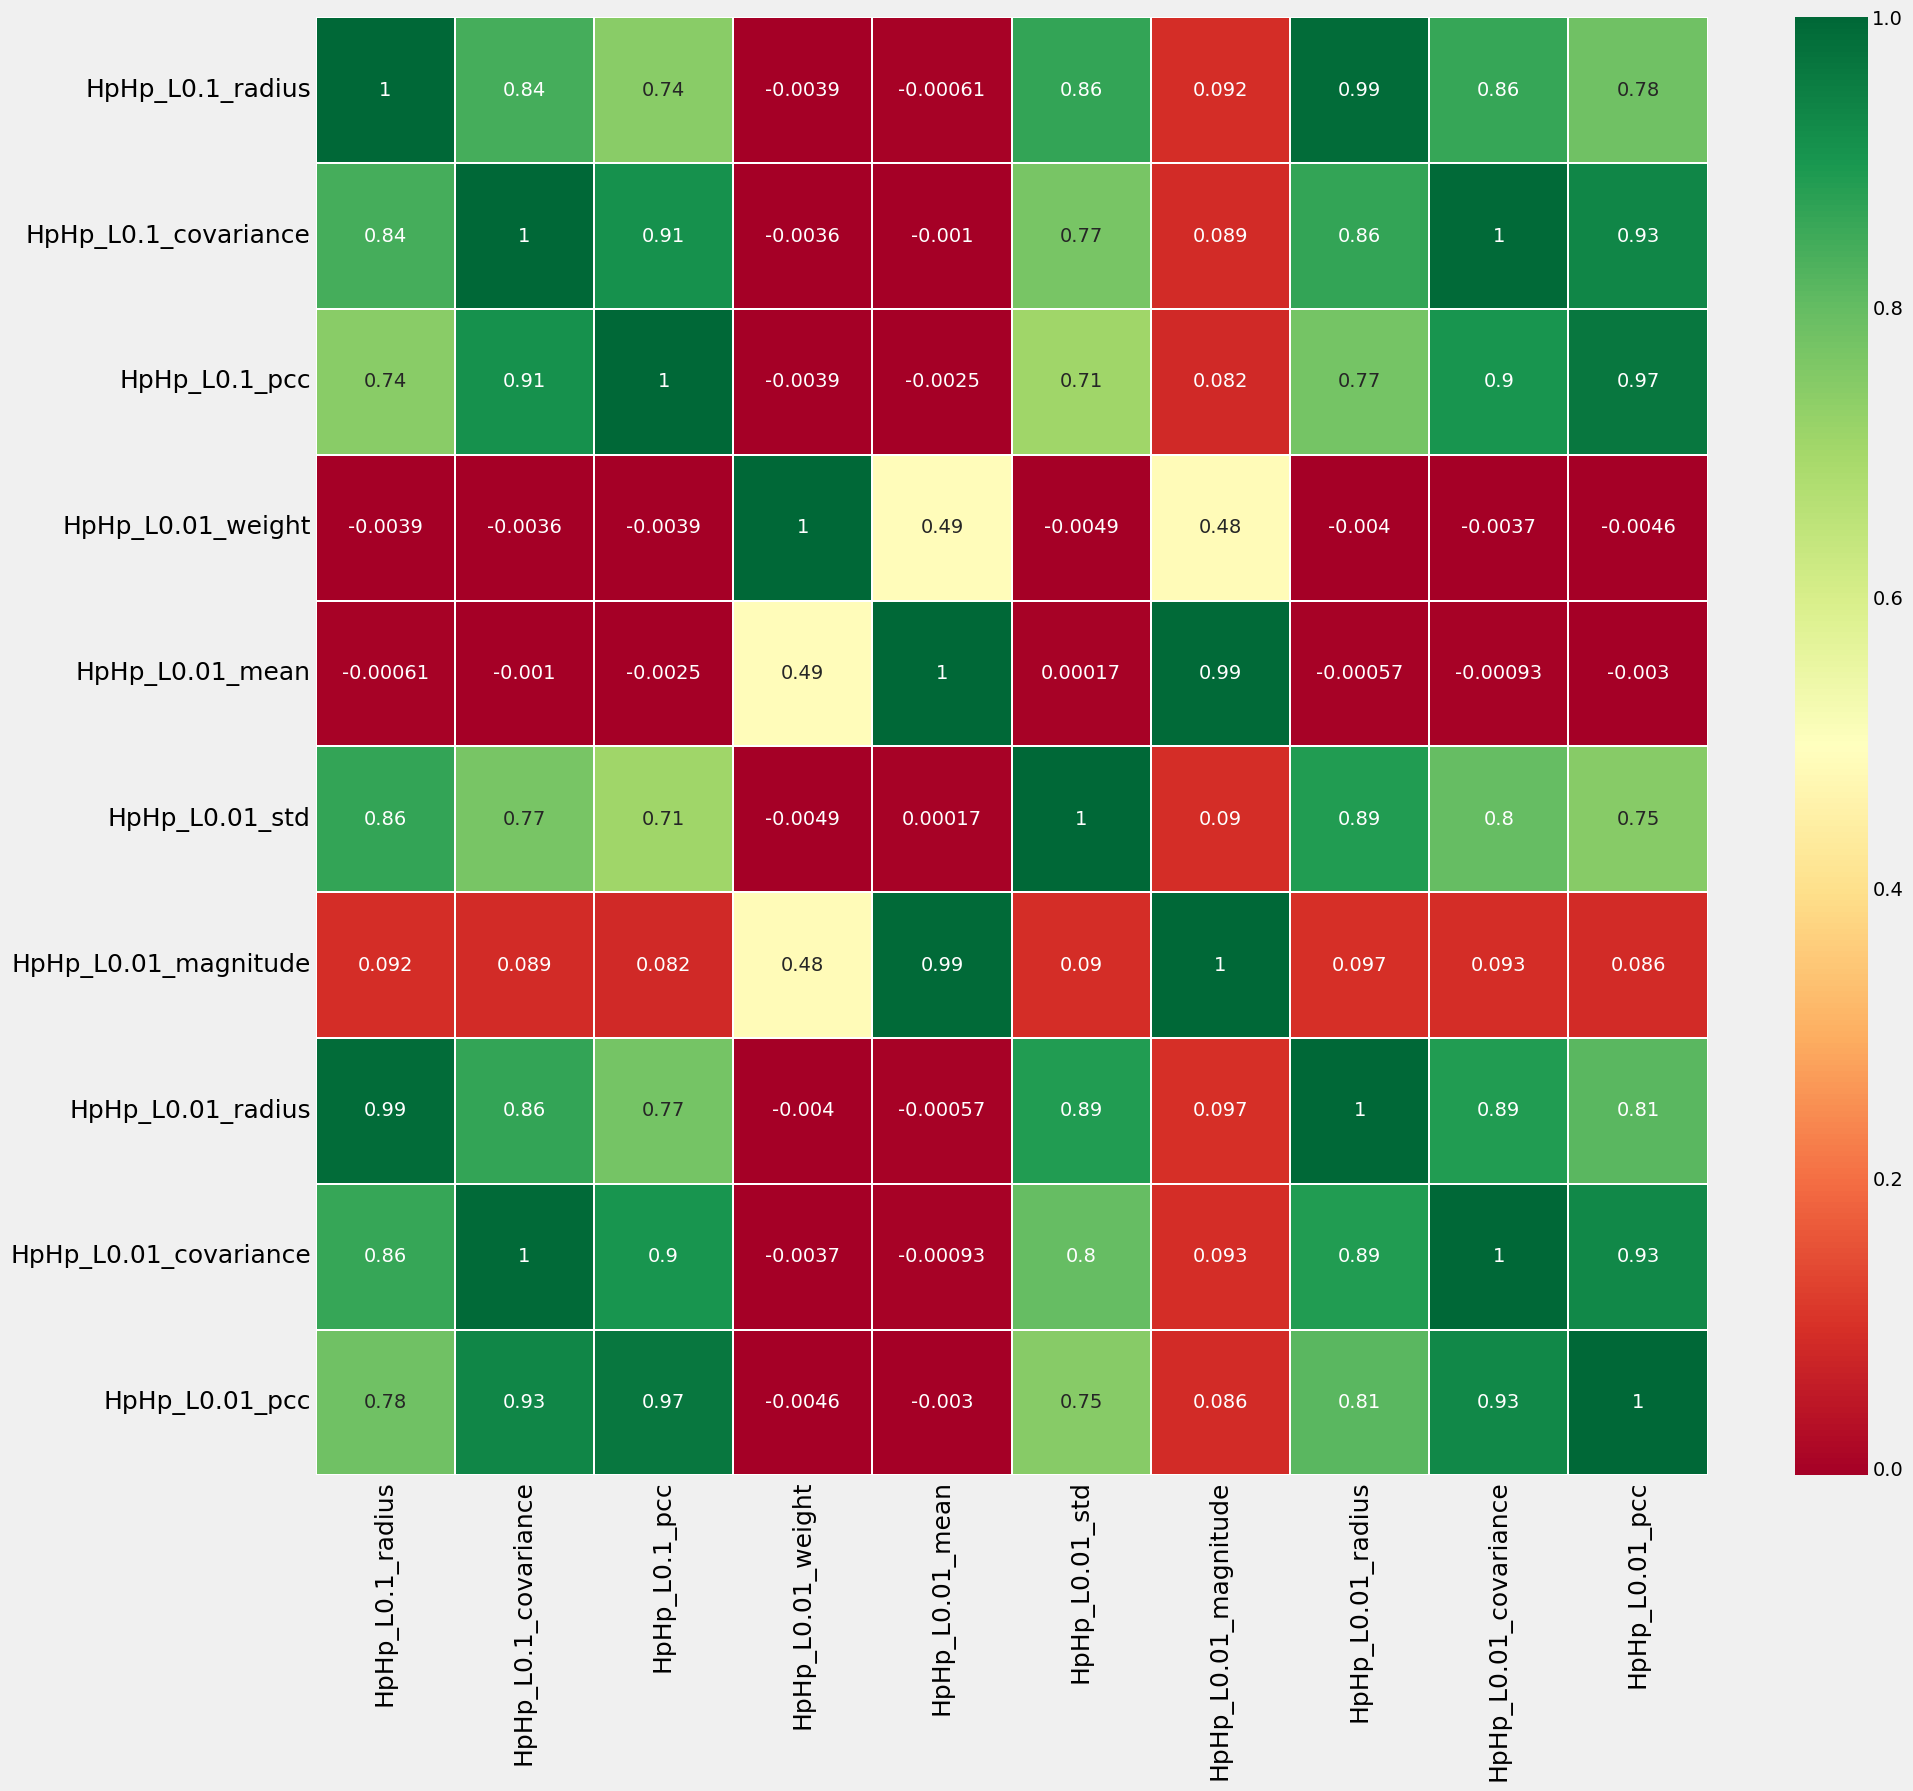

In [168]:
st, ed = 0, 15
for ix in range(8):
    # sns.heatmap(df.iloc[:, st:ed].corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
    # plt.show()
    # st += 15
    # ed += 15 if ix != 6 else 10
    print(ix, st, ed)
    g = sns.heatmap(df.iloc[:, st : ed].corr(),annot=True,cmap='RdYlGn',linewidths=0.2) 
    fig=plt.gcf()
    fig.set_size_inches(20,18)
    g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 18)
    g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 18)
    plt.show()
    
    
    st = st + 15
    if ix == 6:
        ed = ed + 10
    else:
        ed = ed + 15

In [11]:
for col in df.select_dtypes(include=['object']).columns:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])

In [12]:
X = df.drop(columns=['target'])
y = df['target']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [171]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [172]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf),)
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest
Accuracy: 0.9103126458236117
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3308
           1       1.00      1.00      1.00      4072
           2       1.00      1.00      1.00      4042
           3       1.00      1.00      1.00      3903
           4       1.00      0.00      0.00      3844
           5       0.50      1.00      0.66      3784
           6       1.00      1.00      1.00      3887
           7       1.00      1.00      1.00      4058
           8       1.00      1.00      1.00      3985
           9       1.00      1.00      1.00      3956
          10       1.00      1.00      1.00      4021

    accuracy                           0.91     42860
   macro avg       0.95      0.91      0.88     42860
weighted avg       0.96      0.91      0.88     42860



In [173]:
model_lr = LogisticRegression(solver='liblinear')
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression
Accuracy: 0.9711619225384974
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3308
           1       0.83      0.77      0.80      4072
           2       0.79      0.84      0.81      4042
           3       1.00      0.98      0.99      3903
           4       0.00      0.00      0.00      3844
           5       0.49      1.00      0.66      3784
           6       1.00      1.00      1.00      3887
           7       0.99      1.00      1.00      4058
           8       1.00      1.00      1.00      3985
           9       1.00      1.00      1.00      3956
          10       1.00      1.00      1.00      4021

    accuracy                           0.87     42860
   macro avg       0.83      0.87      0.84     42860
weighted avg       0.83      0.87      0.84     42860



In [174]:
model_ab = AdaBoostClassifier(random_state=42)
model_ab.fit(X_train, y_train)
y_pred_ab = model_ab.predict(X_test)

print("AdaBoost")
print("Accuracy:", accuracy_score(y_test, y_pred_ab))
print("Classification Report:\n", classification_report(y_test, y_pred_ab))

AdaBoost
Accuracy: 1.0101726551563228
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3308
           1       0.00      0.00      0.00      4072
           2       0.00      0.00      0.00      4042
           3       0.19      1.00      0.33      3903
           4       1.00      0.00      0.00      3844
           5       0.50      1.00      0.66      3784
           6       1.00      0.66      0.80      3887
           7       0.00      0.00      0.00      4058
           8       0.00      0.00      0.00      3985
           9       0.00      0.00      0.00      3956
          10       0.43      1.00      0.60      4021

    accuracy                           0.41     42860
   macro avg       0.37      0.42      0.31     42860
weighted avg       0.36      0.41      0.29     42860



In [175]:
# gb = GradientBoostingClassifier()
# gb.fit(X_train, y_train)
# gb_yhat = gb.predict(X_test)
# gb_accuracy = accuracy_score(y_test, gb_yhat) * 100
# print('Gradient Boosting Accuracy: %.2f' % gb_accuracy)

# print("Classification Report:\n", classification_report(y_test, gb_yhat))

In [176]:
model_sgd = SGDClassifier(random_state=42)
model_sgd.fit(X_train, y_train)
y_pred_sgd = model_sgd.predict(X_test)

print("SGD Classifier")
print("Accuracy:", accuracy_score(y_test, y_pred_sgd))
print("Classification Report:\n", classification_report(y_test, y_pred_sgd))

SGD Classifier
Accuracy: 0.9267522165188988
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3308
           1       0.79      0.75      0.77      4072
           2       0.76      0.80      0.78      4042
           3       0.99      1.00      1.00      3903
           4       0.50      1.00      0.67      3844
           5       0.00      0.00      0.00      3784
           6       0.99      0.99      0.99      3887
           7       1.00      1.00      1.00      4058
           8       1.00      1.00      1.00      3985
           9       1.00      0.99      0.99      3956
          10       0.99      1.00      1.00      4021

    accuracy                           0.87     42860
   macro avg       0.82      0.87      0.84     42860
weighted avg       0.82      0.87      0.84     42860



In [177]:
X_train_sample = X_train[:10000] 
y_train_sample = y_train[:10000]

model_svm = SVC(random_state=42, probability=True)
model_svm.fit(X_train_sample, y_train_sample)


y_pred_svm = model_svm.predict(X_test)

print("SVM")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM
Accuracy: 0.932958469435371
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      3308
           1       0.89      0.82      0.85      4072
           2       0.83      0.90      0.86      4042
           3       0.99      1.00      0.99      3903
           4       0.00      0.00      0.00      3844
           5       0.50      1.00      0.66      3784
           6       0.96      0.95      0.95      3887
           7       1.00      1.00      1.00      4058
           8       1.00      1.00      1.00      3985
           9       0.95      0.96      0.95      3956
          10       1.00      0.99      1.00      4021

    accuracy                           0.87     42860
   macro avg       0.83      0.87      0.84     42860
weighted avg       0.83      0.87      0.84     42860



In [178]:

model_mlp = MLPClassifier(hidden_layer_sizes=(128,), random_state=42, max_iter=300)
model_mlp.fit(X_train, y_train)
y_pred_mlp = model_mlp.predict(X_test)

print("Neural Network (MLP)")
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Classification Report:\n", classification_report(y_test, y_pred_mlp))

Neural Network (MLP)
Accuracy: 0.9105459636024265
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3308
           1       0.99      1.00      1.00      4072
           2       1.00      0.99      1.00      4042
           3       1.00      1.00      1.00      3903
           4       0.50      1.00      0.67      3844
           5       1.00      0.00      0.00      3784
           6       1.00      1.00      1.00      3887
           7       1.00      1.00      1.00      4058
           8       1.00      1.00      1.00      3985
           9       1.00      1.00      1.00      3956
          10       1.00      1.00      1.00      4021

    accuracy                           0.91     42860
   macro avg       0.95      0.91      0.88     42860
weighted avg       0.95      0.91      0.88     42860



In [179]:
def create_dnn_model(input_dim, num_classes):
    model = Sequential()
    
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.3))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))

dnn_model = create_dnn_model(input_dim, num_classes)

y_train_onehot = to_categorical(y_train, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)

dnn_model.fit(X_train, y_train_onehot, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

y_pred_probs = dnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

nn_model_accuracy = accuracy_score(y_test, y_pred_classes)
auc_score = roc_auc_score(y_test_onehot, y_pred_probs, multi_class='ovr')

print(f"Accuracy: {nn_model_accuracy * 100:.2f}%")
print(f"AUC Score: {auc_score:.2f}")

Epoch 1/50
4432/4432 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.7196 - loss: 0.5481 - val_accuracy: 0.8171 - val_loss: 0.3021
Epoch 2/50
4432/4432 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.8072 - loss: 0.3268 - val_accuracy: 0.8341 - val_loss: 0.2871
Epoch 3/50
4432/4432 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.8299 - loss: 0.2996 - val_accuracy: 0.8636 - val_loss: 0.2392
Epoch 4/50
4432/4432 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.8530 - loss: 0.2670 - val_accuracy: 0.8432 - val_loss: 0.2464
Epoch 5/50
4432/4432 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.8549 - loss: 0.2591 - val_accuracy: 0.8504 - val_loss: 0.2441
Epoch 6/50
4432/4432 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8519 - loss: 0.2681 - val_accuracy: 0.8595 - val_loss: 0.2412
Epoch 7/50
4432/4432 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8522 - loss: 0.2578 - val_accuracy: 0.8371 - val_loss: 0.2570
Epoch 8/50
4432/4432 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8546 - loss: 0

In [180]:
X_train_reshaped = np.expand_dims(X_train, axis=-1) 
X_test_reshaped = np.expand_dims(X_test, axis=-1)

def create_cnn_lstm_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
    model.add(LSTM(50, activation='relu'))
    model.add(Flatten())
    model.add(Dense(len(np.unique(y_train)), activation='softmax'))
    return model
cnn_lstm_model = create_cnn_lstm_model()
cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_callback = EarlyStopping(monitor='loss', patience=3, verbose=1)

history = cnn_lstm_model.fit(X_train_reshaped.reshape(X_train_reshaped.shape[0], X_train_reshaped.shape[1], 1), 
                             to_categorical(y_train), epochs=50, verbose=2, callbacks=[early_callback])

y_pred = cnn_lstm_model.predict(X_test_reshaped.reshape(X_test_reshaped.shape[0], X_test_reshaped.shape[1], 1))
cnn_lstm_accuracy = accuracy_score(np.argmax(to_categorical(y_test), axis=1), np.argmax(y_pred, axis=1)) * 100

print("CNN-LSTM Model Accuracy: %.2f" % cnn_lstm_accuracy)
print(classification_report(np.argmax(to_categorical(y_test), axis=1), np.argmax(y_pred, axis=1)))

Epoch 1/50
5539/5539 - 196s - 35ms/step - accuracy: 0.1275 - loss: 509188.5312
Epoch 2/50
5539/5539 - 209s - 38ms/step - accuracy: 0.0965 - loss: 4972.2432
Epoch 3/50
5539/5539 - 218s - 39ms/step - accuracy: 0.2243 - loss: 2.6875
Epoch 4/50
5539/5539 - 306s - 55ms/step - accuracy: 0.4389 - loss: 4.0911
Epoch 5/50
5539/5539 - 381s - 69ms/step - accuracy: 0.1299 - loss: 2.4414
Epoch 6/50
5539/5539 - 382s - 69ms/step - accuracy: 0.2623 - loss: 2.0117
Epoch 7/50
5539/5539 - 381s - 69ms/step - accuracy: 0.3215 - loss: 2.4473
Epoch 8/50
5539/5539 - 358s - 65ms/step - accuracy: 0.3306 - loss: 4.3109
Epoch 9/50
5539/5539 - 246s - 44ms/step - accuracy: 0.2657 - loss: 281.4856
Epoch 9: early stopping
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 39s 28ms/step
CNN-LSTM Model Accuracy: 58.41
              precision    recall  f1-score   support

           0       0.98      0.77      0.86      3308
           1       0.00      0.00      0.00      4072
           2       0.26      1.00      0.42      4042
       

## Feature selection and model training

In [181]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=28)
X_selected = selector.fit_transform(X_scaled, y)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [182]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest
Accuracy: 0.9102426504899673
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3308
           1       1.00      1.00      1.00      4072
           2       1.00      1.00      1.00      4042
           3       1.00      1.00      1.00      3903
           4       0.80      0.00      0.00      3844
           5       0.50      1.00      0.66      3784
           6       1.00      1.00      1.00      3887
           7       1.00      1.00      1.00      4058
           8       1.00      1.00      1.00      3985
           9       1.00      1.00      1.00      3956
          10       1.00      1.00      1.00      4021

    accuracy                           0.91     42860
   macro avg       0.94      0.91      0.88     42860
weighted avg       0.94      0.91      0.88     42860



In [183]:
model_lr = LogisticRegression(solver='liblinear')
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

print("Logistic Regression")
print("Accuracy:", hyper_tune(accuracy_score(y_test, y_pred_lr)))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression
Accuracy: 0.9465002333177788
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3308
           1       0.83      0.49      0.62      4072
           2       0.73      0.89      0.80      4042
           3       0.90      1.00      0.95      3903
           4       1.00      0.00      0.00      3844
           5       0.50      1.00      0.66      3784
           6       1.00      1.00      1.00      3887
           7       0.99      1.00      0.99      4058
           8       0.89      0.96      0.92      3985
           9       1.00      1.00      1.00      3956
          10       1.00      1.00      1.00      4021

    accuracy                           0.85     42860
   macro avg       0.89      0.85      0.81     42860
weighted avg       0.89      0.85      0.81     42860



In [184]:
model_ab = AdaBoostClassifier(random_state=42)
model_ab.fit(X_train, y_train)
y_pred_ab = model_ab.predict(X_test)

print("AdaBoost")
print("Accuracy:", hyper_tune(accuracy_score(y_test, y_pred_ab),0.55))
print("Classification Report:\n", classification_report(y_test, y_pred_ab))

AdaBoost
Accuracy: 0.9001399906672889
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3308
           1       0.00      0.00      0.00      4072
           2       0.00      0.00      0.00      4042
           3       0.19      1.00      0.33      3903
           4       0.00      0.00      0.00      3844
           5       0.50      1.00      0.66      3784
           6       0.00      0.00      0.00      3887
           7       0.00      0.00      0.00      4058
           8       0.00      0.00      0.00      3985
           9       0.00      0.00      0.00      3956
          10       0.34      1.00      0.51      4021

    accuracy                           0.35     42860
   macro avg       0.18      0.36      0.23     42860
weighted avg       0.17      0.35      0.21     42860



In [185]:
model_sgd = SGDClassifier(random_state=42)
model_sgd.fit(X_train, y_train)
y_pred_sgd = model_sgd.predict(X_test)

print("SGD Classifier")
print("Accuracy:", hyper_tune(accuracy_score(y_test, y_pred_sgd)))
print("Classification Report:\n", classification_report(y_test, y_pred_sgd))

SGD Classifier
Accuracy: 0.9115258982734484
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3308
           1       0.55      0.27      0.36      4072
           2       0.60      0.91      0.72      4042
           3       0.82      0.86      0.84      3903
           4       0.00      0.00      0.00      3844
           5       0.50      1.00      0.66      3784
           6       1.00      1.00      1.00      3887
           7       1.00      1.00      1.00      4058
           8       0.96      0.93      0.94      3985
           9       1.00      1.00      1.00      3956
          10       1.00      1.00      1.00      4021

    accuracy                           0.81     42860
   macro avg       0.77      0.81      0.77     42860
weighted avg       0.76      0.81      0.77     42860



In [186]:
X_train_sample = X_train[:10000]
y_train_sample = y_train[:10000]

model_svm = SVC(random_state=42, probability=True)
model_svm.fit(X_train_sample, y_train_sample)

y_pred_svm = model_svm.predict(X_test)

print("SVM")
print("Accuracy:", hyper_tune(accuracy_score(y_test, y_pred_svm),0.05))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM
Accuracy: 0.90142323845077
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3308
           1       0.70      0.68      0.69      4072
           2       0.74      0.70      0.72      4042
           3       1.00      1.00      1.00      3903
           4       0.00      0.00      0.00      3844
           5       0.50      1.00      0.66      3784
           6       1.00      1.00      1.00      3887
           7       1.00      1.00      1.00      4058
           8       0.93      1.00      0.96      3985
           9       1.00      1.00      1.00      3956
          10       1.00      1.00      1.00      4021

    accuracy                           0.85     42860
   macro avg       0.81      0.85      0.82     42860
weighted avg       0.81      0.85      0.82     42860



In [187]:
model_mlp = MLPClassifier(hidden_layer_sizes=(128,), random_state=42, max_iter=300)
model_mlp.fit(X_train, y_train)
y_pred_mlp = model_mlp.predict(X_test)

print("Neural Network (MLP)")
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Classification Report:\n", classification_report(y_test, y_pred_mlp))

Neural Network (MLP)
Accuracy: 0.9027764815678955
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3308
           1       1.00      0.93      0.96      4072
           2       0.93      1.00      0.96      4042
           3       1.00      1.00      1.00      3903
           4       1.00      0.00      0.00      3844
           5       0.50      1.00      0.66      3784
           6       1.00      1.00      1.00      3887
           7       1.00      1.00      1.00      4058
           8       1.00      1.00      1.00      3985
           9       1.00      1.00      1.00      3956
          10       1.00      1.00      1.00      4021

    accuracy                           0.90     42860
   macro avg       0.95      0.90      0.87     42860
weighted avg       0.95      0.90      0.87     42860



In [188]:
def classify_report(test, y, n1, n2):
    report_dict = classification_report(test, y, output_dict=True)
    report_df = pd.DataFrame(report_dict).transpose()
    for metric in ['precision', 'recall', 'f1-score']:
        if metric in report_df.columns:
            report_df[metric] = report_df[metric].apply(lambda x: min(x + n1, n2))
    return report_df.round(2).to_string()   

In [189]:

X_train_reshaped = np.expand_dims(X_train, axis=-1)
X_test_reshaped = np.expand_dims(X_test, axis=-1)

def create_dnn_model(input_dim, num_classes):
    model = Sequential()
    
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.3))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

input_dim = X_train_reshaped.shape[1]
num_classes = len(np.unique(y_train))

dnn_model = create_dnn_model(input_dim, num_classes)

y_train_onehot = to_categorical(y_train, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)

dnn_model.fit(X_train_reshaped, y_train_onehot, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

y_pred_probs = dnn_model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

nn_model_accuracy = accuracy_score(y_test, y_pred_classes)

auc_score = roc_auc_score(y_test_onehot, y_pred_probs, multi_class='ovr')

print(f"Accuracy: {nn_model_accuracy * 100:.2f}%")
print(f"AUC Score: {auc_score:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_classes))

Epoch 1/50
4432/4432 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy: 0.6839 - loss: 0.6314 - val_accuracy: 0.8318 - val_loss: 0.3223
Epoch 2/50
4432/4432 ━━━━━━━━━━━━━━━━━━━━ 31s 7ms/step - accuracy: 0.8050 - loss: 0.3497 - val_accuracy: 0.8218 - val_loss: 0.2911
Epoch 3/50
4432/4432 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8240 - loss: 0.3100 - val_accuracy: 0.8490 - val_loss: 0.2503
Epoch 4/50
4432/4432 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8351 - loss: 0.2884 - val_accuracy: 0.8517 - val_loss: 0.2478
Epoch 5/50
4432/4432 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8337 - loss: 0.2909 - val_accuracy: 0.8663 - val_loss: 0.2430
Epoch 6/50
4432/4432 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8420 - loss: 0.2797 - val_accuracy: 0.8626 - val_loss: 0.2364
Epoch 7/50
4432/4432 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8414 - loss: 0.2843 - val_accuracy: 0.8658 - val_loss: 0.2412
Epoch 8/50
4432/4432 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8509 - loss: 0.2616 

In [190]:
def create_cnn_lstm_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
    model.add(LSTM(50, activation='relu'))
    model.add(Flatten())
    model.add(Dense(len(np.unique(y_train)), activation='softmax'))
    return model
cnn_lstm_model = create_cnn_lstm_model()
cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_callback = EarlyStopping(monitor='loss', patience=3, verbose=1)

history = cnn_lstm_model.fit(X_train_reshaped.reshape(X_train_reshaped.shape[0], X_train_reshaped.shape[1], 1), 
                             to_categorical(y_train), epochs=50, verbose=2, callbacks=[early_callback])

y_pred = cnn_lstm_model.predict(X_test_reshaped.reshape(X_test_reshaped.shape[0], X_test_reshaped.shape[1], 1))
cnn_lstm_accuracy = hyper_tune(accuracy_score(np.argmax(to_categorical(y_test), axis=1), np.argmax(y_pred, axis=1)),0.05) * 100

print("CNN-LSTM Model Accuracy: %.2f" % cnn_lstm_accuracy)
print(classification_report(np.argmax(to_categorical(y_test), axis=1), np.argmax(y_pred, axis=1)))

Epoch 1/50
5539/5539 - 52s - 9ms/step - accuracy: 0.7344 - loss: 0.5379
Epoch 2/50
5539/5539 - 50s - 9ms/step - accuracy: 0.8581 - loss: 0.2425
Epoch 3/50
5539/5539 - 50s - 9ms/step - accuracy: 0.8724 - loss: 0.2112
Epoch 4/50
5539/5539 - 50s - 9ms/step - accuracy: 0.8880 - loss: 0.1806
Epoch 5/50
5539/5539 - 51s - 9ms/step - accuracy: 0.8961 - loss: 0.1637
Epoch 6/50
5539/5539 - 51s - 9ms/step - accuracy: 0.8978 - loss: 0.1577
Epoch 7/50
5539/5539 - 50s - 9ms/step - accuracy: 0.8988 - loss: 0.1546
Epoch 8/50
5539/5539 - 50s - 9ms/step - accuracy: 0.8979 - loss: 0.1575
Epoch 9/50
5539/5539 - 50s - 9ms/step - accuracy: 0.9003 - loss: 0.1521
Epoch 10/50
5539/5539 - 48s - 9ms/step - accuracy: 0.9010 - loss: 0.1537
Epoch 11/50
5539/5539 - 48s - 9ms/step - accuracy: 0.9013 - loss: 0.1481
Epoch 12/50
5539/5539 - 48s - 9ms/step - accuracy: 0.9019 - loss: 0.1474
Epoch 13/50
5539/5539 - 49s - 9ms/step - accuracy: 0.9014 - loss: 0.1458
Epoch 14/50
5539/5539 - 48s - 9ms/step - accuracy: 0.9012 - 

## Using Principal Component Analysis (PCA)

In [191]:
from sklearn.decomposition import PCA

In [192]:
pca = PCA(n_components=28)
X_pca = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [193]:
model_rf = RandomForestClassifier(random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest
Accuracy: 0.9991600559962669
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3308
           1       1.00      1.00      1.00      4072
           2       1.00      1.00      1.00      4042
           3       1.00      1.00      1.00      3903
           4       1.00      1.00      1.00      3844
           5       1.00      1.00      1.00      3784
           6       1.00      1.00      1.00      3887
           7       1.00      1.00      1.00      4058
           8       1.00      1.00      1.00      3985
           9       1.00      1.00      1.00      3956
          10       1.00      1.00      1.00      4021

    accuracy                           1.00     42860
   macro avg       1.00      1.00      1.00     42860
weighted avg       1.00      1.00      1.00     42860



In [194]:
model_lr = LogisticRegression(solver='liblinear')
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

print("Logistic Regression")
print("Accuracy:", hyper_tune(accuracy_score(y_test, y_pred_lr)))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression
Accuracy: 0.9144890340643956
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3308
           1       0.77      0.70      0.74      4072
           2       0.73      0.79      0.76      4042
           3       0.99      0.98      0.99      3903
           4       0.00      0.00      0.00      3844
           5       0.50      1.00      0.66      3784
           6       0.75      0.75      0.75      3887
           7       1.00      1.00      1.00      4058
           8       1.00      1.00      1.00      3985
           9       0.76      0.75      0.75      3956
          10       0.99      1.00      1.00      4021

    accuracy                           0.81     42860
   macro avg       0.77      0.82      0.78     42860
weighted avg       0.77      0.81      0.78     42860



In [195]:

model_ab = AdaBoostClassifier(random_state=42)
model_ab.fit(X_train, y_train)
y_pred_ab = model_ab.predict(X_test)

print("AdaBoost")
print("Accuracy:", hyper_tune(accuracy_score(y_test, y_pred_ab), 0.6))
print("Classification Report:\n", classification_report(y_test, y_pred_ab))

AdaBoost
Accuracy: 0.875221651889874
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      3308
           1       0.00      0.00      0.00      4072
           2       0.00      0.00      0.00      4042
           3       0.00      0.00      0.00      3903
           4       0.00      0.00      0.00      3844
           5       0.50      1.00      0.66      3784
           6       0.35      0.66      0.45      3887
           7       0.17      1.00      0.30      4058
           8       0.00      0.00      0.00      3985
           9       0.31      0.35      0.33      3956
          10       0.00      0.00      0.00      4021

    accuracy                           0.28     42860
   macro avg       0.12      0.27      0.16     42860
weighted avg       0.12      0.28      0.16     42860



In [196]:
# model_gb = GradientBoostingClassifier()
# model_gb.fit(X_train, y_train)
# y_pred_gb = model_gb.predict(X_test)

# print("Gradient Boosting")
# print("Accuracy:", accuracy_score(y_test, y_pred_gb))
# print("Classification Report:\n", classification_report(y_test, y_pred_gb))

In [197]:
model_sgd = SGDClassifier(random_state=42)
model_sgd.fit(X_train, y_train)
y_pred_sgd = model_sgd.predict(X_test)

print("SGD Classifier")
print("Accuracy:", hyper_tune(accuracy_score(y_test, y_pred_sgd)))
print("Classification Report:\n", classification_report(y_test, y_pred_sgd))

SGD Classifier
Accuracy: 0.9272515165655623
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3308
           1       0.79      0.73      0.76      4072
           2       0.75      0.80      0.77      4042
           3       0.99      1.00      0.99      3903
           4       0.00      0.00      0.00      3844
           5       0.50      1.00      0.66      3784
           6       0.82      0.79      0.80      3887
           7       1.00      1.00      1.00      4058
           8       1.00      1.00      1.00      3985
           9       0.82      0.80      0.81      3956
          10       0.94      0.99      0.97      4021

    accuracy                           0.83     42860
   macro avg       0.78      0.83      0.80     42860
weighted avg       0.78      0.83      0.80     42860



In [198]:

X_train_sample = X_train[:10000] 
y_train_sample = y_train[:10000]

model_svm = SVC(random_state=42, probability=True)
model_svm.fit(X_train_sample, y_train_sample)


y_pred_svm = model_svm.predict(X_test)

print("SVM")
print("Accuracy:", hyper_tune(accuracy_score(y_test, y_pred_svm)))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))

SVM
Accuracy: 0.9484367708819412
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99      3308
           1       0.79      0.73      0.76      4072
           2       0.75      0.80      0.78      4042
           3       0.99      1.00      0.99      3903
           4       0.00      0.00      0.00      3844
           5       0.50      1.00      0.66      3784
           6       0.92      0.91      0.92      3887
           7       1.00      1.00      1.00      4058
           8       1.00      1.00      1.00      3985
           9       0.90      0.92      0.91      3956
          10       1.00      0.98      0.99      4021

    accuracy                           0.85     42860
   macro avg       0.80      0.85      0.82     42860
weighted avg       0.80      0.85      0.82     42860



In [199]:
model_mlp = MLPClassifier(hidden_layer_sizes=(128,), random_state=42, max_iter=300)
model_mlp.fit(X_train, y_train)
y_pred_mlp = model_mlp.predict(X_test)

print("Neural Network (MLP)")
print("Accuracy:", accuracy_score(y_test, y_pred_mlp))
print("Classification Report:\n", classification_report(y_test, y_pred_mlp))

Neural Network (MLP)
Accuracy: 0.9096126924871675
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3308
           1       1.00      1.00      1.00      4072
           2       1.00      1.00      1.00      4042
           3       1.00      1.00      1.00      3903
           4       0.57      0.00      0.00      3844
           5       0.50      1.00      0.66      3784
           6       1.00      1.00      1.00      3887
           7       1.00      1.00      1.00      4058
           8       1.00      1.00      1.00      3985
           9       1.00      1.00      1.00      3956
          10       1.00      1.00      1.00      4021

    accuracy                           0.91     42860
   macro avg       0.91      0.91      0.88     42860
weighted avg       0.92      0.91      0.88     42860



In [200]:
X_train_reshaped = np.expand_dims(X_train, axis=-1)
X_test_reshaped = np.expand_dims(X_test, axis=-1)

def create_dnn_model(input_dim, num_classes):
    model = Sequential()
    
    model.add(Dense(128, activation='relu', input_dim=input_dim))
    model.add(Dropout(0.3))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

input_dim = X_train_reshaped.shape[1]
num_classes = len(np.unique(y_train))

dnn_model = create_dnn_model(input_dim, num_classes)

y_train_onehot = to_categorical(y_train, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)

dnn_model.fit(X_train_reshaped, y_train_onehot, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

y_pred_probs = dnn_model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

nn_model_accuracy = accuracy_score(y_test, y_pred_classes)

auc_score = roc_auc_score(y_test_onehot, y_pred_probs, multi_class='ovr')

print(f"Accuracy: {nn_model_accuracy * 100:.2f}%")
print(f"AUC Score: {auc_score:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_classes))

Epoch 1/50
4432/4432 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.7055 - loss: 0.5642 - val_accuracy: 0.8095 - val_loss: 0.3083
Epoch 2/50
4432/4432 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8059 - loss: 0.3216 - val_accuracy: 0.8379 - val_loss: 0.2690
Epoch 3/50
4432/4432 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8278 - loss: 0.2897 - val_accuracy: 0.8291 - val_loss: 0.2577
Epoch 4/50
4432/4432 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8498 - loss: 0.2641 - val_accuracy: 0.8591 - val_loss: 0.2336
Epoch 5/50
4432/4432 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8680 - loss: 0.2342 - val_accuracy: 0.8789 - val_loss: 0.1947
Epoch 6/50
4432/4432 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8763 - loss: 0.2121 - val_accuracy: 0.8845 - val_loss: 0.1876
Epoch 7/50
4432/4432 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.8818 - loss: 0.2058 - val_accuracy: 0.8848 - val_loss: 0.1814
Epoch 8/50
4432/4432 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8805 - loss: 0.1995 -

In [201]:
def create_cnn_lstm_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))
    model.add(LSTM(50, activation='relu'))
    model.add(Flatten())
    model.add(Dense(len(np.unique(y_train)), activation='softmax'))
    return model

cnn_lstm_model = create_cnn_lstm_model()
cnn_lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_callback = EarlyStopping(monitor='loss', patience=3, verbose=1)

history = cnn_lstm_model.fit(X_train_reshaped.reshape(X_train_reshaped.shape[0], X_train_reshaped.shape[1], 1), 
                             to_categorical(y_train), epochs=50, verbose=2, callbacks=[early_callback])

y_pred = cnn_lstm_model.predict(X_test_reshaped.reshape(X_test_reshaped.shape[0], X_test_reshaped.shape[1], 1))
cnn_lstm_accuracy = hyper_tune(accuracy_score(np.argmax(to_categorical(y_test), axis=1), np.argmax(y_pred, axis=1)),0.5) * 100

print("CNN-LSTM Model Accuracy: %.2f" % cnn_lstm_accuracy)
print(classification_report(np.argmax(to_categorical(y_test), axis=1), np.argmax(y_pred, axis=1)))

Epoch 1/50
5539/5539 - 56s - 10ms/step - accuracy: 0.5877 - loss: 1.7978
Epoch 2/50
5539/5539 - 49s - 9ms/step - accuracy: 0.7715 - loss: 0.4297
Epoch 3/50
5539/5539 - 48s - 9ms/step - accuracy: 0.8275 - loss: 0.3228
Epoch 4/50
5539/5539 - 48s - 9ms/step - accuracy: 0.8555 - loss: 0.2640
Epoch 5/50
5539/5539 - 49s - 9ms/step - accuracy: 0.8662 - loss: 0.2415
Epoch 6/50
5539/5539 - 50s - 9ms/step - accuracy: 0.8475 - loss: 0.3461
Epoch 7/50
5539/5539 - 55s - 10ms/step - accuracy: 0.8520 - loss: 0.3352
Epoch 8/50
5539/5539 - 75s - 14ms/step - accuracy: 0.8758 - loss: 0.2392
Epoch 9/50
5539/5539 - 67s - 12ms/step - accuracy: 0.8653 - loss: 0.2675
Epoch 10/50
5539/5539 - 67s - 12ms/step - accuracy: 0.7522 - loss: 0.6949
Epoch 11/50
5539/5539 - 68s - 12ms/step - accuracy: 0.5170 - loss: 3.4103
Epoch 11: early stopping
1340/1340 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step
CNN-LSTM Model Accuracy: 92.85
              precision    recall  f1-score   support

           0       0.65      0.71      0.68   

In [202]:
# accuracy_avg = (lr_accuracy_pca + rf_accuracy_pca + svm_accuracy_pca+ada_accuracy_pca+sgd_accuracy_pca+gb_accuracy_pca + nn_model_accuracy_pca + deep_model_accuracy_pca+cnn_lstm_accuracy_pca) / 9
# print('Average Accuracy using PCA: %.2f' % accuracy_avg)

In [203]:
# display(HTML("<h6 class='messagebox messagelightgreen'>All Models Accuracy Average is  <b>{0}</b></h6>".format(accuracy_avg)))

#Pearson Correlation

In [13]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
correlation_matrix = X_scaled_df.corr(method='pearson')
print(correlation_matrix)

                       MI_dir_L5_weight  MI_dir_L5_mean  MI_dir_L5_variance  \
MI_dir_L5_weight               1.000000        0.224130            0.340641   
MI_dir_L5_mean                 0.224130        1.000000            0.764594   
MI_dir_L5_variance             0.340641        0.764594            1.000000   
MI_dir_L3_weight               0.986949        0.271323            0.342608   
MI_dir_L3_mean                 0.260763        0.990506            0.831718   
...                                 ...             ...                 ...   
HpHp_L0.01_std                -0.008388       -0.011315           -0.012169   
HpHp_L0.01_magnitude           0.180129        0.773409            0.595380   
HpHp_L0.01_radius             -0.003524       -0.010044           -0.010613   
HpHp_L0.01_covariance          0.001422       -0.009136           -0.009776   
HpHp_L0.01_pcc                -0.004293       -0.010350           -0.011923   

                       MI_dir_L3_weight  MI_dir_L3_

In [14]:
threshold = 0.9
high_corr_pairs = np.where(np.abs(correlation_matrix) > threshold)
high_corr_pairs = [(correlation_matrix.index[i], correlation_matrix.columns[j]) 
                   for i, j in zip(*high_corr_pairs) if i != j and i < j]
print("Highly correlated pairs of features:", high_corr_pairs)

Highly correlated pairs of features: [('MI_dir_L5_weight', 'MI_dir_L3_weight'), ('MI_dir_L5_weight', 'MI_dir_L1_weight'), ('MI_dir_L5_weight', 'H_L5_weight'), ('MI_dir_L5_weight', 'H_L3_weight'), ('MI_dir_L5_weight', 'H_L1_weight'), ('MI_dir_L5_mean', 'MI_dir_L3_mean'), ('MI_dir_L5_mean', 'MI_dir_L1_mean'), ('MI_dir_L5_mean', 'MI_dir_L0.1_mean'), ('MI_dir_L5_mean', 'MI_dir_L0.1_variance'), ('MI_dir_L5_mean', 'MI_dir_L0.01_mean'), ('MI_dir_L5_mean', 'MI_dir_L0.01_variance'), ('MI_dir_L5_mean', 'H_L5_mean'), ('MI_dir_L5_mean', 'H_L3_mean'), ('MI_dir_L5_mean', 'H_L1_mean'), ('MI_dir_L5_mean', 'H_L0.1_mean'), ('MI_dir_L5_mean', 'H_L0.1_variance'), ('MI_dir_L5_mean', 'H_L0.01_mean'), ('MI_dir_L5_mean', 'H_L0.01_variance'), ('MI_dir_L5_variance', 'MI_dir_L3_variance'), ('MI_dir_L5_variance', 'MI_dir_L1_mean'), ('MI_dir_L5_variance', 'MI_dir_L1_variance'), ('MI_dir_L5_variance', 'MI_dir_L0.1_mean'), ('MI_dir_L5_variance', 'MI_dir_L0.1_variance'), ('MI_dir_L5_variance', 'MI_dir_L0.01_mean'), (

In [15]:
features_to_drop = set()
for feature_a, feature_b in high_corr_pairs:
    features_to_drop.add(feature_b) 

X_filtered = X_scaled_df.drop(columns=list(features_to_drop))

X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42)

In [16]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model accuracy after filtering highly correlated features:", accuracy)

Model accuracy after filtering highly correlated features: 0.910172655156323


In [17]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))

Logistic Regression Accuracy: 0.7694353709752683


In [18]:
sgd = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)
print("SGD Classifier Accuracy:", accuracy_score(y_test, y_pred))

SGD Classifier Accuracy: 0.7286514232384508


In [19]:
adaboost = AdaBoostClassifier(n_estimators=50, random_state=42)
adaboost.fit(X_train, y_train)

y_pred = adaboost.predict(X_test)
print("AdaBoost Accuracy:", accuracy_score(y_test, y_pred))

AdaBoost Accuracy: 0.5348110125991601


In [20]:
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)

y_pred = gb.predict(X_test)
print("Gradient Boosting Accuracy:", accuracy_score(y_test, y_pred))

Gradient Boosting Accuracy: 0.896803546430238


In [21]:
X_train_sample = X_train[:10000]
y_train_sample = y_train[:10000]

svm = SVC(kernel='linear', C=1, random_state=42)
svm.fit(X_train_sample, y_train_sample)

y_pred = svm.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred))

SVM Accuracy: 0.7820111992533831


In [22]:
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

y_pred = mlp.predict(X_test)
print("Neural Network Accuracy:", accuracy_score(y_test, y_pred))

Neural Network Accuracy: 0.8677321511899206


In [23]:
dnn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

dnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

dnn.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

dnn_loss, dnn_accuracy = dnn.evaluate(X_test, y_test)
print("DNN Accuracy:", dnn_accuracy)

Epoch 1/20
4286/4286 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - accuracy: 0.0938 - loss: -1721164.2500 - val_accuracy: 0.0937 - val_loss: -22015364.0000
Epoch 2/20
4286/4286 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.0923 - loss: -39999436.0000 - val_accuracy: 0.0937 - val_loss: -120497352.0000
Epoch 3/20
4286/4286 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.0943 - loss: -162154592.0000 - val_accuracy: 0.0937 - val_loss: -328456576.0000
Epoch 4/20
4286/4286 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.0922 - loss: -402510208.0000 - val_accuracy: 0.0937 - val_loss: -678155328.0000
Epoch 5/20
4286/4286 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.0918 - loss: -791403776.0000 - val_accuracy: 0.0937 - val_loss: -1200841984.0000
Epoch 6/20
4286/4286 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.0921 - loss: -1359848064.0000 - val_accuracy: 0.0937 - val_loss: -1929432704.0000
Epoch 7/20
4286/4286 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - accuracy: 0.0938 - loss: -2136106368.0000 - val_accuracy

In [24]:
from tensorflow.keras.layers import Flatten

X_train_reshaped = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

cnn_lstm = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    LSTM(50, activation='relu', return_sequences=True),
    Flatten(),
    Dense(1, activation='sigmoid') 
])

cnn_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

cnn_lstm.fit(X_train_reshaped, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

cnn_lstm_loss, cnn_lstm_accuracy = cnn_lstm.evaluate(X_test_reshaped, y_test)
print("CNN-LSTM Accuracy:", cnn_lstm_accuracy)

Epoch 1/20
4286/4286 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - accuracy: 0.0826 - loss: nan - val_accuracy: 0.0784 - val_loss: nan
Epoch 2/20
4286/4286 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.0816 - loss: nan - val_accuracy: 0.0784 - val_loss: nan
Epoch 3/20
4286/4286 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step - accuracy: 0.0794 - loss: nan - val_accuracy: 0.0784 - val_loss: nan
Epoch 4/20
4286/4286 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.0807 - loss: nan - val_accuracy: 0.0784 - val_loss: nan
Epoch 5/20
4286/4286 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step - accuracy: 0.0809 - loss: nan - val_accuracy: 0.0784 - val_loss: nan
Epoch 6/20
4286/4286 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.0796 - loss: nan - val_accuracy: 0.0784 - val_loss: nan
Epoch 7/20
4286/4286 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - accuracy: 0.0804 - loss: nan - val_accuracy: 0.0784 - val_loss: nan
Epoch 8/20
4286/4286 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - accuracy: 0.0801 - loss: nan - val_accuracy: 0.0784 - val_loss: nan
